In [1]:
# Data management
# ------------------------------------------------------------------------------
import numpy as np
from numpy import mean
from numpy import std
import pandas as pd

# Graphics
# ------------------------------------------------------------------------------
import matplotlib.pyplot as plt
%matplotlib inline

# Preprocessing and modelling
# evaluate bagging ensemble for regression
# ------------------------------------------------------------------------------
#from sklearn.datasets import load_boston
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.inspection import permutation_importance
import multiprocessing

from sklearn import metrics
from sklearn.metrics import mean_squared_error


import lightgbm





# Configuración warnings
# ------------------------------------------------------------------------------
import warnings
#warnings.filterwarnings('once')
warnings.filterwarnings('ignore')

In [2]:
# Data Loading


#training data
data_train = pd.read_csv('https://raw.githubusercontent.com/SantiagoArenas/MachineLearning/main/austinHousingData.csv')
data_train.head()



zpid          city          streetAddress  zipcode  \
0   111373431  pflugerville   14424 Lake Victor Dr    78660   
1   120900430  pflugerville     1104 Strickling Dr    78660   
2  2084491383  pflugerville    1408 Fort Dessau Rd    78660   
3   120901374  pflugerville     1025 Strickling Dr    78660   
4    60134862  pflugerville  15005 Donna Jane Loop    78660   

                                         description   latitude  longitude  \
0  14424 Lake Victor Dr, Pflugerville, TX 78660 i...  30.430632 -97.663078   
1  Absolutely GORGEOUS 4 Bedroom home with 2 full...  30.432673 -97.661697   
2  Under construction - estimated completion in A...  30.409748 -97.639771   
3  Absolutely darling one story home in charming ...  30.432112 -97.661659   
4  Brimming with appeal & warm livability! Sleek ...  30.437368 -97.656860   

   propertyTaxRate  garageSpaces  hasAssociation  ...  numOfMiddleSchools  \
0             1.98             2            True  ...                   1   
1             1.98             2            True  ...                   1   
2             1.98             0            True  ...                   1   
3             1.98             2            True  ...                   1   
4             1.98             0            True  ...                   1   

   numOfHighSchools  avgSchoolDistance  avgSchoolRating  avgSchoolSize  \
0                 1           1.266667         2.666667           1063   
1                 1           1.400000         2.666667           1063   
2                 1           1.200000         3.000000           1108   
3                 1           1.400000         2.666667           1063   
4                 1           1.133333         4.000000           1223   

  MedianStudentsPerTeacher  numOfBathrooms  numOfBedrooms  numOfStories  \
0                       14             3.0              4             2   
1                       14             2.0              4             1   
2                       14             2.0              3             1   
3                       14             2.0              3             1   
4                       14             3.0              3             2   

                                           homeImage  
0  111373431_ffce26843283d3365c11d81b8e6bdc6f-p_f...  
1  120900430_8255c127be8dcf0a1a18b7563d987088-p_f...  
2  2084491383_a2ad649e1a7a098111dcea084a11c855-p_...  
3  120901374_b469367a619da85b1f5ceb69b675d88e-p_f...  
4  60134862_b1a48a3df3f111e005bb913873e98ce2-p_f.jpg  

[5 rows x 47 columns]

In [3]:
# Columnas descartables de inicio
data_train = data_train.drop(["description","homeImage","zpid","streetAddress","latest_saledate","latestPriceSource", 'garageSpaces'], axis=1)
#Cogemos los datos que queremos
data_train = data_train[data_train['city'] == 'austin']
data_train = data_train[data_train['homeType'] == 'Single Family']
#Tiene los mismos valores siempre, entonces no aporta nada
data_train = data_train.drop(["city","homeType"], axis=1)

In [4]:
numeric_cols = data_train.select_dtypes(include=['float64', 'int64']).columns.to_list()
cat_cols = data_train.select_dtypes(include=['object', 'category', 'bool']).columns.to_list()

In [5]:
#Prefijos para las dummies
new_column_names = [
    'Dmy_association',
    'Dmy_cooling',
    'Dmy_garage',
    'Dmy_heating',
    'Dmy_spa',
    'Dmy_view'
]
data=pd.get_dummies(data_train, columns=cat_cols, prefix=new_column_names,drop_first=True, dtype= 'int64' ) 
print(data.dtypes)

zipcode                         int64
latitude                      float64
longitude                     float64
propertyTaxRate               float64
parkingSpaces                   int64
yearBuilt                       int64
latestPrice                   float64
numPriceChanges                 int64
latest_salemonth                int64
latest_saleyear                 int64
numOfPhotos                     int64
numOfAccessibilityFeatures      int64
numOfAppliances                 int64
numOfParkingFeatures            int64
numOfPatioAndPorchFeatures      int64
numOfSecurityFeatures           int64
numOfWaterfrontFeatures         int64
numOfWindowFeatures             int64
numOfCommunityFeatures          int64
lotSizeSqFt                   float64
livingAreaSqFt                float64
numOfPrimarySchools             int64
numOfElementarySchools          int64
numOfMiddleSchools              int64
numOfHighSchools                int64
avgSchoolDistance             float64
avgSchoolRat

In [6]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14096 entries, 17 to 15170
Data columns (total 38 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   zipcode                     14096 non-null  int64  
 1   latitude                    14096 non-null  float64
 2   longitude                   14096 non-null  float64
 3   propertyTaxRate             14096 non-null  float64
 4   hasAssociation              14096 non-null  bool   
 5   hasCooling                  14096 non-null  bool   
 6   hasGarage                   14096 non-null  bool   
 7   hasHeating                  14096 non-null  bool   
 8   hasSpa                      14096 non-null  bool   
 9   hasView                     14096 non-null  bool   
 10  parkingSpaces               14096 non-null  int64  
 11  yearBuilt                   14096 non-null  int64  
 12  latestPrice                 14096 non-null  float64
 13  numPriceChanges             14

In [7]:
# Configuring train and test datasets
# ------------------------------------------------------------------------------
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
                                        data.drop(columns = "latestPrice"),
                                        data['latestPrice'],
                                        random_state = 123,
                                        test_size=0.2
                                    )


In [8]:
# Model ussing Gradient Boosting

# - Does not binning
# - Uses a single core (does not parallelize any part of the algorithm)
# - Allows working on sparse matrices
# - Necessary to do one-hot-encoding of categorical variables

In [9]:
# Simple Model creation
# ==============================================================================
model = GradientBoostingRegressor(
            n_estimators = 15,
            loss         = 'squared_error',
            max_features = 'sqrt',
            random_state = 123
         )

# Model trainingEntrenamiento del modelo
# ==============================================================================
model.fit(X_train, y_train)

GradientBoostingRegressor(max_features='sqrt', n_estimators=15,
                          random_state=123)

In [10]:
# Model training error
#-------------------------------------------------------------------------------
prediction_train = model.predict(X = X_train)


#Measuring Goodness of fit in Training data

print('R2 Value in training:', round(metrics.r2_score(y_train, prediction_train),2))

#Measuring accuracy on Testing Data
print('Accuracy in training',round( 100- (np.mean(np.abs((y_train - prediction_train) / y_train)) * 100), 2))
      
 
residuals_train=y_train - prediction_train


rmse = mean_squared_error(
        y_true  = y_train,
        y_pred  = prediction_train,
        squared = False
       )
print(f"RMSE in train: {rmse}")

R2 Value in training: 0.51
Accuracy in training 59.52
RMSE in train: 321523.1799553517


In [11]:
# Model test error
#-------------------------------------------------------------------------------
prediction_test = model.predict(X = X_test)


#Measuring accuracy on Testing Data
print('Accuracy in test',round( 100- (np.mean(np.abs((y_test - prediction_test) / y_test)) * 100), 2))
      
 
residuals_testn=y_test - prediction_test

rmse = mean_squared_error(
        y_true  = y_test,
        y_pred  = prediction_test,
        squared = False
       )
print(f"RMSE in test: {rmse}")

Accuracy in test 49.67
RMSE in test: 262138.53558373445


Optimum value for n_estimators: 476


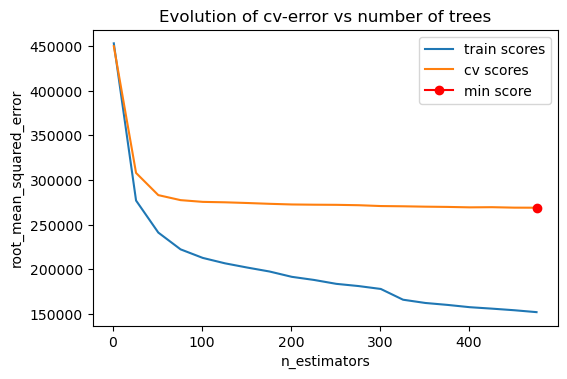

In [12]:
# the number of trees is searched based on k-cross-validation & neg_root_mean_squared_error
# ==============================================================================
train_scores = []
cv_scores    = []

# Valores evaluados
estimator_range = range(1, 500, 25)

# Bucle para entrenar un modelo con cada valor de n_estimators y extraer su error
# de entrenamiento y de k-cross-validation.
for n_estimators in estimator_range:
    
    modelo = GradientBoostingRegressor(
                n_estimators = n_estimators,
                loss         = 'squared_error',
                max_features = 'sqrt',
                random_state = 123
             )
    
    # Error de train
    modelo.fit(X_train, y_train)
    predicciones = modelo.predict(X = X_train)
    rmse = mean_squared_error(
            y_true  = y_train,
            y_pred  = predicciones,
            squared = False
           )
    train_scores.append(rmse)
    
    # Error de validación cruzada
    scores = cross_val_score(
                estimator = modelo,
                X         = X_train,
                y         = y_train,
                scoring   = 'neg_root_mean_squared_error',
                cv        = 5,
                n_jobs    = multiprocessing.cpu_count() - 1,
             )
    # Se agregan los scores de cross_val_score() y se pasa a positivo
    cv_scores.append(-1*scores.mean())
    
# Gráfico con la evolución de los errores
fig, ax = plt.subplots(figsize=(6, 3.84))
ax.plot(estimator_range, train_scores, label="train scores")
ax.plot(estimator_range, cv_scores, label="cv scores")
ax.plot(estimator_range[np.argmin(cv_scores)], min(cv_scores),
        marker='o', color = "red", label="min score")
ax.set_ylabel("root_mean_squared_error")
ax.set_xlabel("n_estimators")
ax.set_title("Evolution of cv-error vs number of trees")
plt.legend();
print(f"Optimum value for n_estimators: {estimator_range[np.argmin(cv_scores)]}")

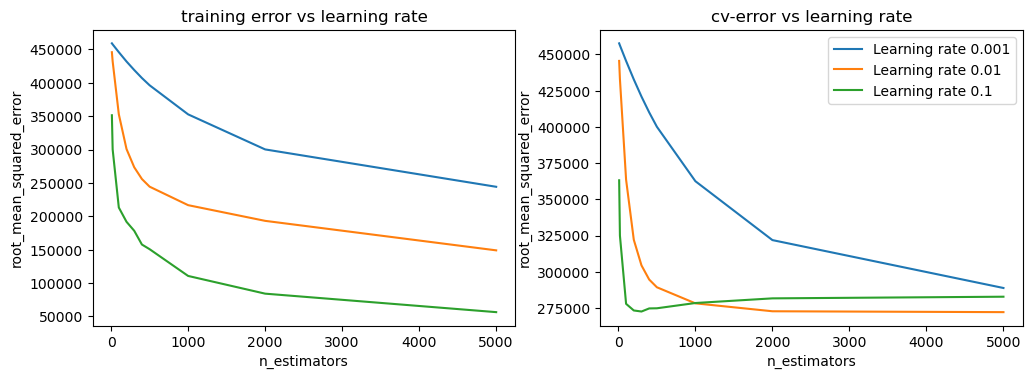

In [13]:
# Learning rate is tested based on k-cross-validation & neg_root_mean_squared_error
# ==============================================================================
results = {}

# Values tested
learning_rates = [0.001, 0.01, 0.1]
n_estimators   = [10, 20, 100, 200, 300, 400, 500, 1000, 2000, 5000]


# Loop for trining the model trying combinations of  learning_rate & n_estimator 
# Obtaining training error & k-cross-validation error.
for learning_rate in learning_rates:
    train_scores = []
    cv_scores    = []
    
    for n_estimator in n_estimators:
    
        model = GradientBoostingRegressor(
                    n_estimators  = n_estimator,
                    learning_rate = learning_rate,
                    loss          = 'squared_error',
                    max_features  = 'sqrt',
                    random_state  = 123
                 )

        # Error de train
        model.fit(X_train, y_train)
        predictions = model.predict(X = X_train)
        rmse = mean_squared_error(
                y_true  = y_train,
                y_pred  = predictions,
                squared = False
               )
        train_scores.append(rmse)

        # Error of CV
        scores = cross_val_score(
                    estimator = model,
                    X         = X_train,
                    y         = y_train,
                    scoring   = 'neg_root_mean_squared_error',
                    cv        = 3,
                    n_jobs    = multiprocessing.cpu_count() - 1
                 )
        # Aggregating scores of cross_val_score() and changing sign to positive
        cv_scores.append(-1*scores.mean())
        
    results[learning_rate] = {'train_scores': train_scores, 'cv_scores': cv_scores}

# Graphic presenting the error evolution
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 3.84))

for key, value in results.items():
    axs[0].plot(n_estimators, value['train_scores'], label=f"Learning rate {key}")
    axs[0].set_ylabel("root_mean_squared_error")
    axs[0].set_xlabel("n_estimators")
    axs[0].set_title("training error vs learning rate")
    
    axs[1].plot(n_estimators, value['cv_scores'], label=f"Learning rate {key}")
    axs[1].set_ylabel("root_mean_squared_error")
    axs[1].set_xlabel("n_estimators")
    axs[1].set_title("cv-error vs learning rate")
    plt.legend();

Optimum value of max_depth: 10


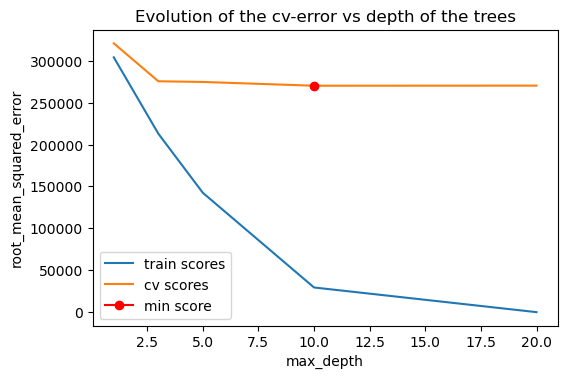

In [14]:
# Searching max-depth using k-cross-validation & neg_root_mean_squared_error
# ==============================================================================
train_scores = []
cv_scores    = []

# Values tested
max_depths = [1, 3, 5, 10, 20]

# Loop for training the model for each valie in max_depth & obtining the training error
# and the k-cross-validation error.
for max_depth in max_depths:
    
    model = GradientBoostingRegressor(
                n_estimators = 100,
                loss         = 'squared_error',
                max_depth    = max_depth,
                max_features = 'sqrt',
                random_state = 123
             )
    
    # Training error
    model.fit(X_train, y_train)
    predictions = model.predict(X = X_train)
    rmse = mean_squared_error(
            y_true  = y_train,
            y_pred  = predictions,
            squared = False
           )
    train_scores.append(rmse)
    
    # Error of CV
    scores = cross_val_score(
                estimator = model,
                X         = X_train,
                y         = y_train,
                scoring   = 'neg_root_mean_squared_error',
                cv        = 5,
                n_jobs    = multiprocessing.cpu_count() - 1
             )
    # Aggregation of scores of cross_val_score() and changing the sign
    cv_scores.append(-1*scores.mean())
    
# Graphic showing the error evolution
fig, ax = plt.subplots(figsize=(6, 3.84))
ax.plot(max_depths, train_scores, label="train scores")
ax.plot(max_depths, cv_scores, label="cv scores")
ax.plot(max_depths[np.argmin(cv_scores)], min(cv_scores),
        marker='o', color = "red", label="min score")
ax.set_ylabel("root_mean_squared_error")
ax.set_xlabel("max_depth")
ax.set_title("Evolution of the cv-error vs depth of the trees")
plt.legend();
print(f"Optimum value of max_depth: {max_depths[np.argmin(cv_scores)]}")

In [15]:
# Grid Seach based on CV

from sklearn.model_selection import ParameterGrid

# Grid of hiperparameters evaluated
# ==============================================================================
param_grid = {'max_features'  : ['auto', 'sqrt', 'log2'],
              'max_depth'     : [None, 1, 3, 5, 10, 20],
              'subsample'     : [0.5, 1],
              'learning_rate' : [0.001, 0.01, 0.1]
             }

# Gris search by CV
# ==============================================================================
grid = GridSearchCV(
        estimator  = GradientBoostingRegressor(
                        n_estimators        = 1000, 
                        random_state        = 123,
                        # Activation of early stop
                        validation_fraction = 0.1,
                        n_iter_no_change    = 5,
                        tol                 = 0.0001
                    ),
        param_grid = param_grid,
        scoring    = 'neg_root_mean_squared_error',
        n_jobs     = multiprocessing.cpu_count() - 1,
        cv         = RepeatedKFold(n_splits=3, n_repeats=1, random_state=123), 
        refit      = True,
        verbose    = 0,
        return_train_score = True
       )

grid.fit(X = X_train, y = y_train)

# Resultados
# ==============================================================================
results = pd.DataFrame(grid.cv_results_)
results.filter(regex = '(param.*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False) \
    .head(10)

param_learning_rate param_max_depth param_max_features param_subsample  \
63                0.01              10               sqrt               1   
65                0.01              10               log2               1   
62                0.01              10               sqrt             0.5   
69                0.01              20               sqrt               1   
39                0.01            None               sqrt               1   
38                0.01            None               sqrt             0.5   
68                0.01              20               sqrt             0.5   
57                0.01               5               sqrt               1   
71                0.01              20               log2               1   
59                0.01               5               log2               1   

    mean_test_score  std_test_score  mean_train_score  std_train_score  
63   -260410.498147    50192.012271     -97806.089336     47705.386458  
65   -261633.668297    50738.254404    -101756.214396     47816.442624  
62   -263263.590093    47219.750114    -125700.020741     37432.677958  
69   -263476.616009    51500.374301     -93553.429400     47880.372437  
39   -263834.187259    50136.025833     -94418.992617     47953.363647  
38   -264479.727026    47507.598053    -109701.103393     42390.896972  
68   -265716.833627    48010.977346    -109976.004645     40465.508518  
57   -266215.441260    43989.088064    -174063.026388     32272.698846  
71   -267197.105441    50250.227343     -94919.817355     50591.849657  
59   -267267.163011    44207.079276    -177293.390863     37435.743858

In [16]:
# Best hiperparameters using CV
# ==============================================================================
print("----------------------------------------")
print("Best hiperparameters found (cv)")
print("----------------------------------------")
print(grid.best_params_, ":", grid.best_score_, grid.scoring)

----------------------------------------
Best hiperparameters found (cv)
----------------------------------------
{'learning_rate': 0.01, 'max_depth': 10, 'max_features': 'sqrt', 'subsample': 1} : -260410.4981474936 neg_root_mean_squared_error


In [17]:
# Although it has been indicated that n_estimator = 1000, due to the activation of 
# the early stop, the training may have stopped earlier.

# Number of trees of the final model (early stopping activated)
# ==============================================================================
print(f"Number of trees of the final model: {grid.best_estimator_.n_estimators_}")

Number of trees of the final model: 566


In [18]:
# Selecting Best model
model_final = grid.best_estimator_

In [19]:
# Final Model training error
#-------------------------------------------------------------------------------
prediction_train = model_final.predict(X = X_train)


#Measuring Goodness of fit in Training data

print('R2 Value in training:', round(metrics.r2_score(y_train, prediction_train),2))

#Measuring accuracy on Testing Data
print('Accuracy in training',round( 100- (np.mean(np.abs((y_train - prediction_train) / y_train)) * 100), 2))
      
 
residuals_train=y_train - prediction_train


rmse = mean_squared_error(
        y_true  = y_train,
        y_pred  = prediction_train,
        squared = False
       )
print(f"RMSE in train: {rmse}")

R2 Value in training: 0.93
Accuracy in training 89.17
RMSE in train: 123688.63831188642


In [20]:
# Model test error
#-------------------------------------------------------------------------------
prediction_test = model_final.predict(X = X_test)


#Measuring accuracy on Testing Data
print('Accuracy in test',round( 100- (np.mean(np.abs((y_test - prediction_test) / y_test)) * 100), 2))
      
 
residuals_testn=y_test - prediction_test

rmse = mean_squared_error(
        y_true  = y_test,
        y_pred  = prediction_test,
        squared = False
       )
print(f"RMSE in test: {rmse}")

Accuracy in test 58.98
RMSE in test: 185378.44210833308


In [21]:
importance_predictors = pd.DataFrame(
                            {'predictor': data_train.drop(columns = "latestPrice").columns,
                             'importance': model_final.feature_importances_}
                            )
print("Importance of the model predictors")
print("-------------------------------------------")
importance_predictors.sort_values('importance', ascending=False)

Importance of the model predictors
-------------------------------------------


predictor  importance
19  numOfPatioAndPorchFeatures    0.229025
28          numOfMiddleSchools    0.117380
18        numOfParkingFeatures    0.098560
1                     latitude    0.066412
0                      zipcode    0.065582
2                    longitude    0.055115
26         numOfPrimarySchools    0.040528
29            numOfHighSchools    0.038031
25              livingAreaSqFt    0.036859
5                   hasCooling    0.035409
24                 lotSizeSqFt    0.030221
27      numOfElementarySchools    0.021580
9                      hasView    0.018276
4               hasAssociation    0.016561
6                    hasGarage    0.015945
31             avgSchoolRating    0.013470
7                   hasHeating    0.013093
11                   yearBuilt    0.013021
30           avgSchoolDistance    0.008782
3              propertyTaxRate    0.006961
35               numOfBedrooms    0.006699
8                       hasSpa    0.006631
15                 numOfPhotos    0.006197
12             numPriceChanges    0.006153
13            latest_salemonth    0.005856
21     numOfWaterfrontFeatures    0.005543
23      numOfCommunityFeatures    0.005264
14             latest_saleyear    0.003961
36                numOfStories    0.003549
20       numOfSecurityFeatures    0.002979
16  numOfAccessibilityFeatures    0.002327
33    MedianStudentsPerTeacher    0.002018
22         numOfWindowFeatures    0.001293
32               avgSchoolSize    0.000237
10               parkingSpaces    0.000196
17             numOfAppliances    0.000153
34              numOfBathrooms    0.000136

In [22]:
from sklearn.inspection import permutation_importance

importance_per = permutation_importance(
                estimator    = model_final,
                X            = X_train,
                y            = y_train,
                n_repeats    = 5,
                scoring      = 'neg_root_mean_squared_error',
                n_jobs       = - 1,
                random_state = 123
             )

# Se almacenan los resultados (media y desviación) en un dataframe
df_importance = pd.DataFrame(
                    {k: importance_per[k] for k in ['importances_mean', 'importances_std']}
                 )
df_importance['feature'] = X_train.columns
df_importance.sort_values('importances_mean', ascending=False)

importances_mean  importances_std                     feature
19     178837.422440      3066.489160              livingAreaSqFt
28      65918.651806       637.100516              numOfBathrooms
18      59155.968669       775.877826                 lotSizeSqFt
0       54720.256659       971.698820                     zipcode
1       45826.124914      4172.306536                    latitude
2       44865.483866      2733.140706                   longitude
25      26046.110990      1648.440995             avgSchoolRating
26      25976.114506      3839.613439               avgSchoolSize
5       20956.158090      1232.830814                   yearBuilt
29      18216.984396       268.724280               numOfBedrooms
6       13060.715812       478.051290             numPriceChanges
27      12637.676042       718.473935    MedianStudentsPerTeacher
24      11565.328105      1220.355289           avgSchoolDistance
9        8904.525484      1316.595784                 numOfPhotos
31       7902.097006       842.822969        Dmy_association_True
11       7012.088633       632.707972             numOfAppliances
7        4812.666498      1309.958444            latest_salemonth
8        4115.672462       235.707475             latest_saleyear
4        3480.801080       163.768166               parkingSpaces
3        2939.667156       264.185481             propertyTaxRate
30       2799.956262       329.361732                numOfStories
15       2625.256688        40.109346     numOfWaterfrontFeatures
13       2138.329880       256.963540  numOfPatioAndPorchFeatures
35       2136.154959       229.446919                Dmy_spa_True
21       1651.594750       309.348899      numOfElementarySchools
23       1476.503163       232.004954            numOfHighSchools
36       1304.678563        73.822598               Dmy_view_True
12       1078.378102        82.046671        numOfParkingFeatures
14        775.086530       190.124702       numOfSecurityFeatures
16        726.865375       218.810818         numOfWindowFeatures
20        627.490655       150.711403         numOfPrimarySchools
33        269.517085       153.640805             Dmy_garage_True
22        140.180254        15.922566          numOfMiddleSchools
32         81.919759         3.353808            Dmy_cooling_True
10         63.955390         3.947634  numOfAccessibilityFeatures
34         52.156121         3.282796            Dmy_heating_True
17         24.217023         9.018742      numOfCommunityFeatures

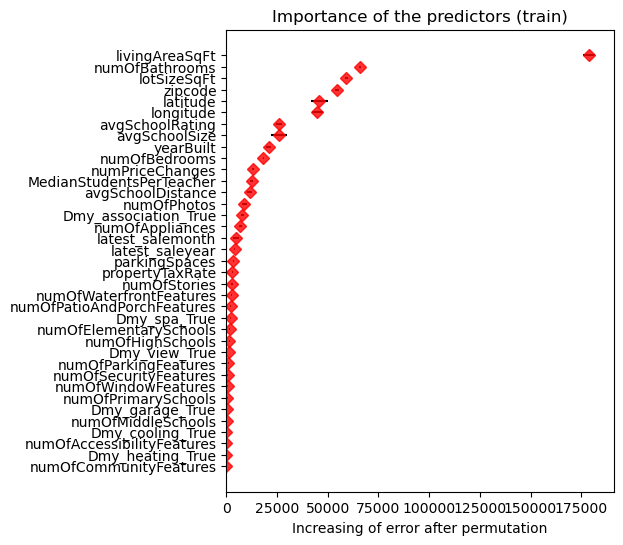

In [23]:
# Graphic
fig, ax = plt.subplots(figsize=(5, 6))
df_importance = df_importance.sort_values('importances_mean', ascending=True)
ax.barh(
    df_importance['feature'],
    df_importance['importances_mean'],
    xerr=df_importance['importances_std'],
    align='center',
    alpha=0
)
ax.plot(
    df_importance['importances_mean'],
    df_importance['feature'],
    marker="D",
    linestyle="",
    alpha=0.8,
    color="r"
)
ax.set_title('Importance of the predictors (train)')
ax.set_xlabel('Increasing of error after permutation');

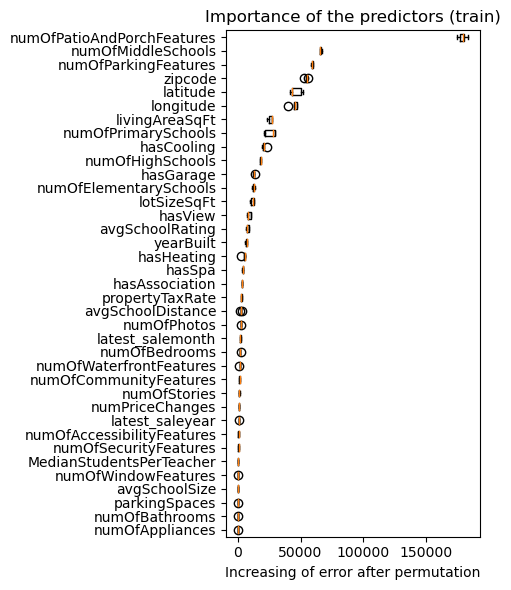

In [24]:
# Graphic Alternative
fig, ax = plt.subplots(figsize=(5, 6))
sorted_idx = importance_per.importances_mean.argsort()
ax.boxplot(
        importance_per.importances[sorted_idx].T,
        vert   = False,
        labels = data_train.drop(columns = "latestPrice").columns[sorted_idx]
)
ax.set_title('Importance of the predictors (train)')
ax.set_xlabel('Increasing of error after permutation');
fig.tight_layout();

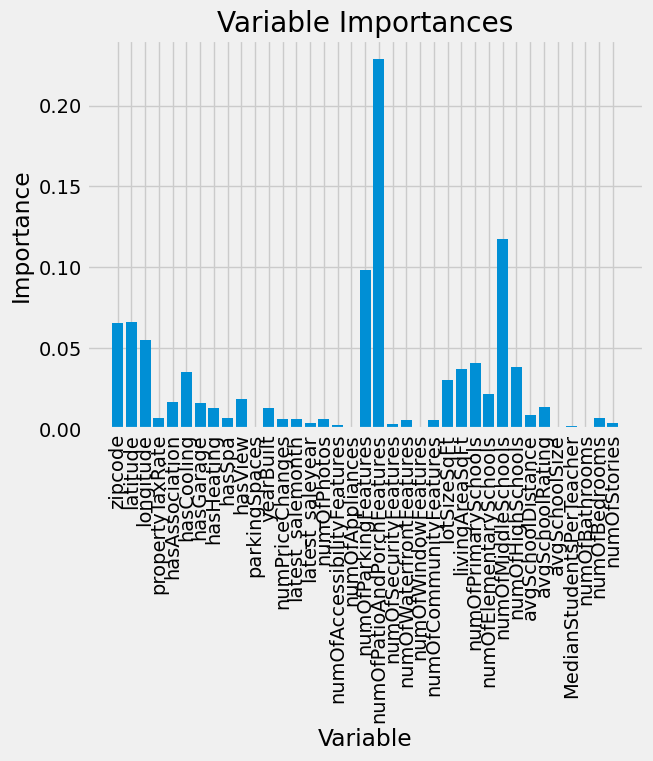

In [25]:
importances= model_final.feature_importances_
feature_list = data_train.drop(columns = "latestPrice").columns

%matplotlib inline
# Set the style
plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

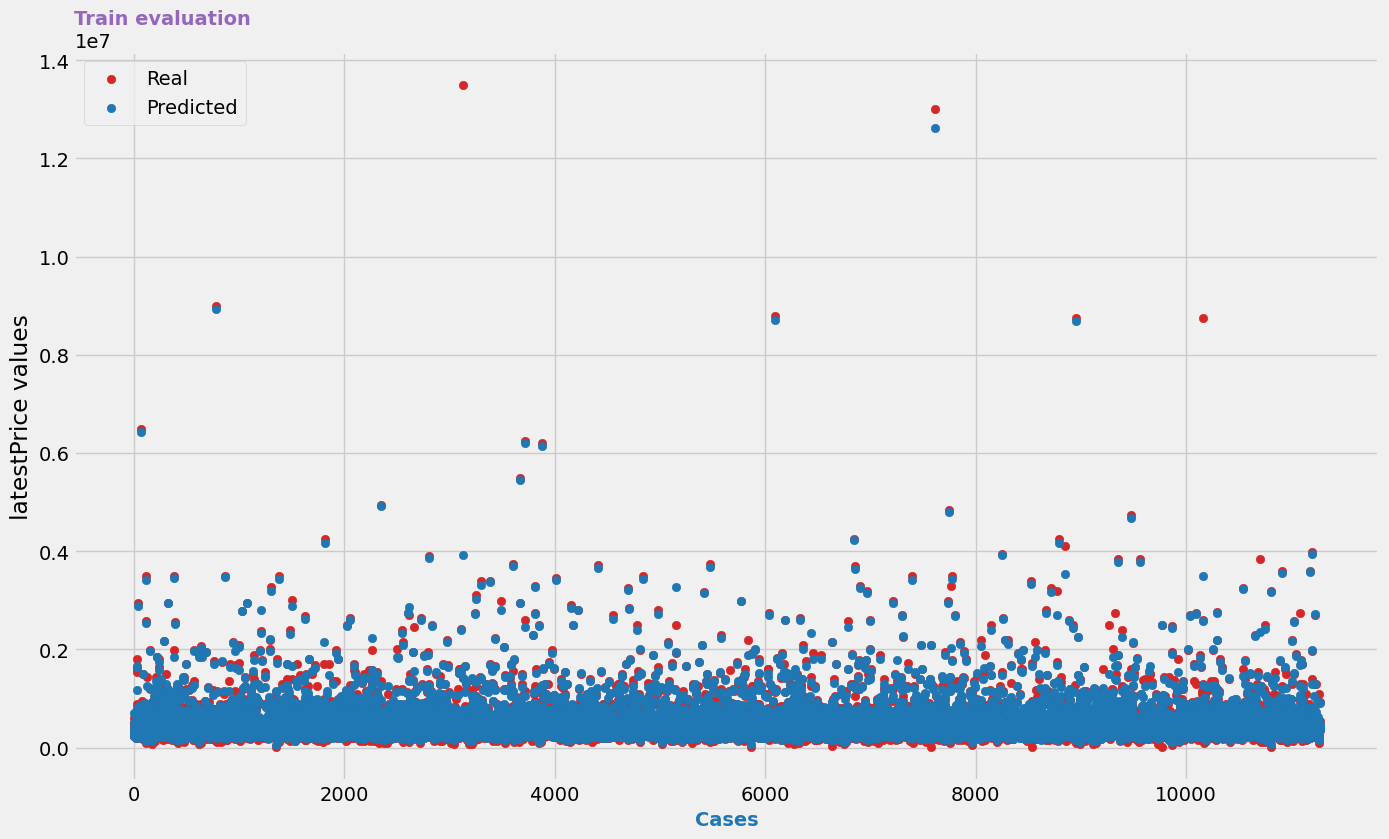

In [26]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15, 9))


x_axis=list(range(len(y_train)))

ax.scatter(x_axis, y_train, color = 'tab:red', label='Real')
ax.scatter(x_axis, prediction_train, color = 'tab:blue', label='Predicted')
ax.set_xlabel("Cases", fontdict = {'fontsize':14, 'fontweight':'bold', 'color':'tab:blue'})
ax.set_ylabel("latestPrice values")
ax.set_title('Train evaluation', loc = "left", fontdict = {'fontsize':14, 'fontweight':'bold', 'color':'tab:purple'})
ax.legend(loc = 'upper left')
plt.show()

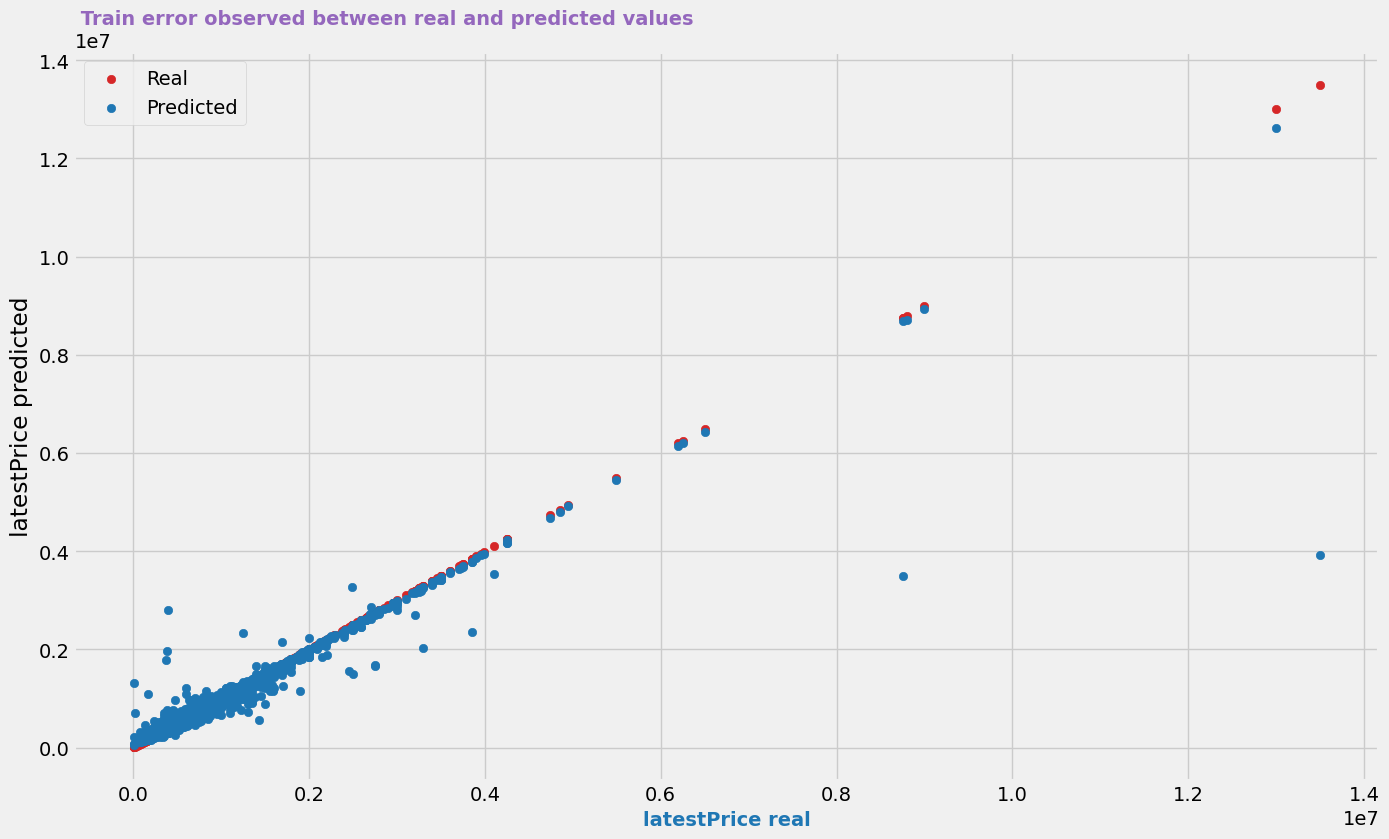

In [27]:
#######  TRAIN

fig, ax = plt.subplots(figsize=(15, 9))


#x_axis=list(range(len(y_train)))

ax.scatter(y_train, y_train, color = 'tab:red', label='Real')
ax.scatter(y_train, prediction_train, color = 'tab:blue', label='Predicted')
ax.set_xlabel("latestPrice real", fontdict = {'fontsize':14, 'fontweight':'bold', 'color':'tab:blue'})
ax.set_ylabel("latestPrice predicted")
ax.set_title(' Train error observed between real and predicted values', loc = "left", fontdict = {'fontsize':14, 'fontweight':'bold', 'color':'tab:purple'})
ax.legend(loc = 'upper left')
plt.show()

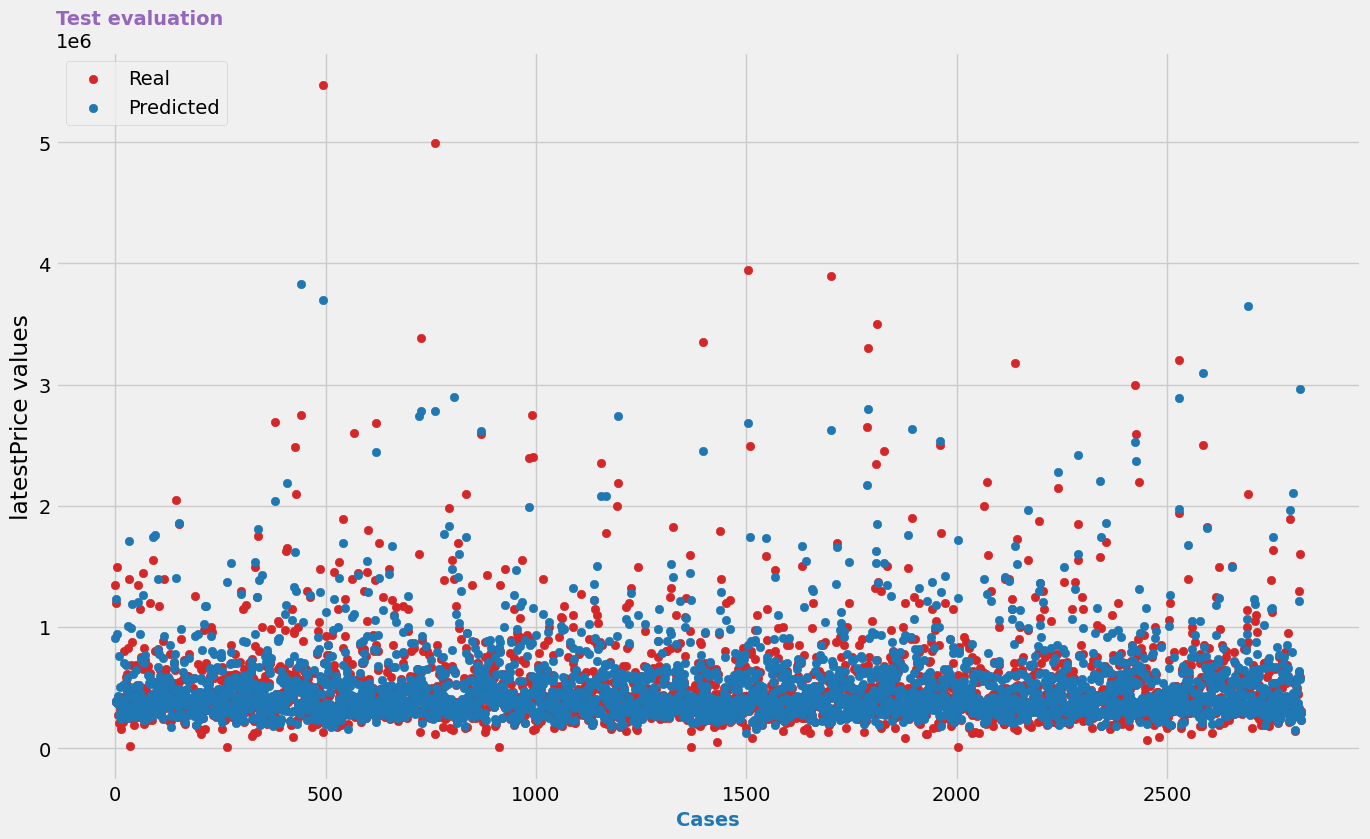

In [28]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15, 9))


x_axis=list(range(len(y_test)))

ax.scatter(x_axis, y_test, color = 'tab:red', label='Real')
ax.scatter(x_axis, prediction_test, color = 'tab:blue', label='Predicted')
ax.set_xlabel("Cases", fontdict = {'fontsize':14, 'fontweight':'bold', 'color':'tab:blue'})
ax.set_ylabel("latestPrice values")
ax.set_title('Test evaluation', loc = "left", fontdict = {'fontsize':14, 'fontweight':'bold', 'color':'tab:purple'})
ax.legend(loc = 'upper left')
plt.show()

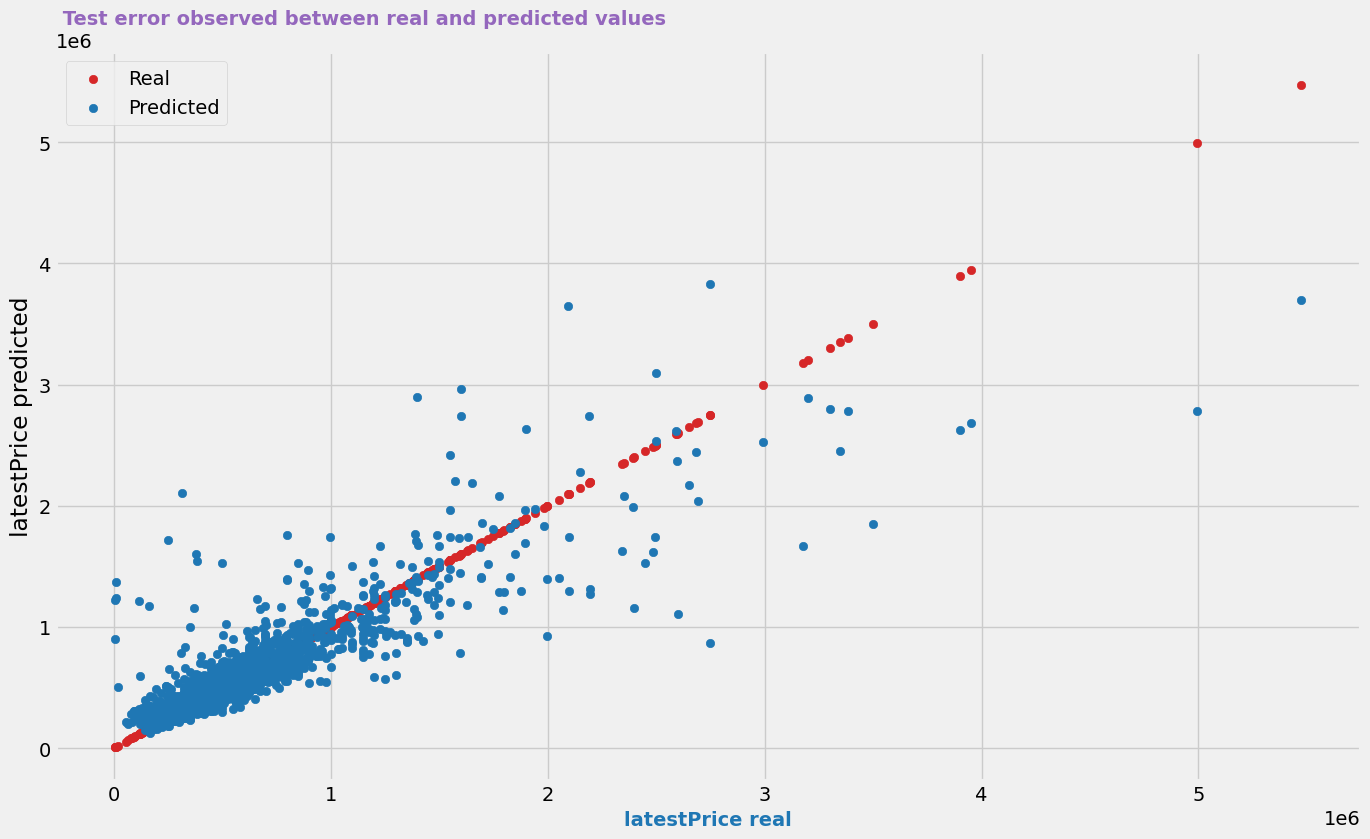

In [29]:
#######  TEST

fig, ax = plt.subplots(figsize=(15, 9))


#x_axis=list(range(len(y_train)))

ax.scatter(y_test, y_test, color = 'tab:red', label='Real')
ax.scatter(y_test, prediction_test, color = 'tab:blue', label='Predicted')
ax.set_xlabel("latestPrice real", fontdict = {'fontsize':14, 'fontweight':'bold', 'color':'tab:blue'})
ax.set_ylabel("latestPrice predicted")
ax.set_title(' Test error observed between real and predicted values', loc = "left", fontdict = {'fontsize':14, 'fontweight':'bold', 'color':'tab:purple'})
ax.legend(loc = 'upper left')
plt.show()

In [30]:
# Model based on XGBoost:
# - Allows observations to include missing values
# - Allows the use of GPUs
# - Parallelized training (parallelizes some parts of the algorithm)
# - Allow monotonic constraints
# - Allows working on sparse matrices
# - Required one-hot-encoding of categorical variables

In [31]:
# Instalación XGBoost: conda install -c conda-forge xgboost
from xgboost import XGBRegressor

In [32]:
# Grid of the hipermarameters to evaluate
# ==============================================================================
param_grid = {'max_depth'        : [None, 1, 3, 5, 10, 20],
              'subsample'        : [0.5, 1],
              'learning_rate'    : [0.001, 0.01, 0.1],
              'booster'          : ['gbtree']
             }


# Creation of a validation dataset
# ==============================================================================
np.random.seed(123)
idx_validacion = np.random.choice(
                    X_train.shape[0],
                    size= int(X_train.shape[0]*0.1),
                    replace=False
                 )

X_val = X_train.iloc[idx_validacion, :].copy()
y_val = y_train.iloc[idx_validacion].copy()

X_train_grid = X_train.reset_index(drop = True).drop(idx_validacion, axis = 0).copy()
y_train_grid = y_train.reset_index(drop = True).drop(idx_validacion, axis = 0).copy()

# XGBoost requires to pass the specific parameters for training calling the methodd .fit()
fit_params = {"early_stopping_rounds" : 5, 
              "eval_metric"           : "rmse", 
              "eval_set"              : [(X_val, y_val)],
              "verbose"               : 0
             }

# grid search with CV
# ==============================================================================
grid = GridSearchCV(
        estimator  = XGBRegressor(
                        n_estimators = 1000,
                        random_state = 123
                    ),
        param_grid = param_grid,
        scoring    = 'neg_root_mean_squared_error',
        n_jobs     = multiprocessing.cpu_count() - 1,
        cv         = RepeatedKFold(n_splits=3, n_repeats=1, random_state=123), 
        refit      = True,
        verbose    = 0,
        return_train_score = True
       )

grid.fit(X = X_train_grid, y = y_train_grid, **fit_params)

# Results
# ==============================================================================
results = pd.DataFrame(grid.cv_results_)
results.filter(regex = '(param.*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False) \
    .head(10)

/Users/santi/anaconda3/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/santi/anaconda3/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/santi/anaconda3/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/santi/anaconda3/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in construct

param_booster param_learning_rate param_max_depth param_subsample  \
20        gbtree                0.01              10             0.5   
22        gbtree                0.01              20             0.5   
12        gbtree                0.01            None             0.5   
31        gbtree                 0.1               5               1   
18        gbtree                0.01               5             0.5   
24        gbtree                 0.1            None             0.5   
30        gbtree                 0.1               5             0.5   
29        gbtree                 0.1               3               1   
34        gbtree                 0.1              20             0.5   
32        gbtree                 0.1              10             0.5   

    mean_test_score  std_test_score  mean_train_score  std_train_score  
20   -258453.355859    44323.739244     -98423.359476     22773.524507  
22   -258721.205073    44389.370101     -92738.294875     12770.338433  
12   -259847.416523    43528.663906    -136922.239152     14276.218829  
31   -262233.580999    46054.191849    -111304.846847     15553.359837  
18   -262596.640333    42635.560980    -157319.392587     16200.784760  
24   -264604.610968    38069.997885    -139270.417443     26055.353010  
30   -264771.892829    40296.607196    -161022.644748      5413.267044  
29   -267055.986056    42583.357809    -217946.345122     29556.929478  
34   -267694.592882    41039.963445     -69493.625812     26493.204426  
32   -267881.861771    37409.661083     -75593.366662     15747.283915

In [33]:
# Best hiperparameters using CV
# ==============================================================================
print("----------------------------------------")
print("Best hiperparameters found (cv)")
print("----------------------------------------")
print(grid.best_params_, ":", grid.best_score_, grid.scoring)

----------------------------------------
Best hiperparameters found (cv)
----------------------------------------
{'booster': 'gbtree', 'learning_rate': 0.01, 'max_depth': 10, 'subsample': 0.5} : -258453.3558585396 neg_root_mean_squared_error


In [34]:
# Number of trees of the final model (early stopping activated)
# ==============================================================================
n_trees_included = len(grid.best_estimator_.get_booster().get_dump())
print(f"Number of trees included in the model: {n_trees_included}")

Number of trees included in the model: 440


In [35]:
from sklearn.inspection import permutation_importance

importance_per = permutation_importance(
                estimator    = model_final,
                X            = X_train,
                y            = y_train,
                n_repeats    = 5,
                scoring      = 'neg_root_mean_squared_error',
                n_jobs       = - 1,
                random_state = 123
             )

# Se almacenan los resultados (media y desviación) en un dataframe
df_importance = pd.DataFrame(
                    {k: importance_per[k] for k in ['importances_mean', 'importances_std']}
                 )
df_importance['feature'] = X_train.columns
df_importance.sort_values('importances_mean', ascending=False)

importances_mean  importances_std                     feature
19     178837.422440      3066.489160              livingAreaSqFt
28      65918.651806       637.100516              numOfBathrooms
18      59155.968669       775.877826                 lotSizeSqFt
0       54720.256659       971.698820                     zipcode
1       45826.124914      4172.306536                    latitude
2       44865.483866      2733.140706                   longitude
25      26046.110990      1648.440995             avgSchoolRating
26      25976.114506      3839.613439               avgSchoolSize
5       20956.158090      1232.830814                   yearBuilt
29      18216.984396       268.724280               numOfBedrooms
6       13060.715812       478.051290             numPriceChanges
27      12637.676042       718.473935    MedianStudentsPerTeacher
24      11565.328105      1220.355289           avgSchoolDistance
9        8904.525484      1316.595784                 numOfPhotos
31       7902.097006       842.822969        Dmy_association_True
11       7012.088633       632.707972             numOfAppliances
7        4812.666498      1309.958444            latest_salemonth
8        4115.672462       235.707475             latest_saleyear
4        3480.801080       163.768166               parkingSpaces
3        2939.667156       264.185481             propertyTaxRate
30       2799.956262       329.361732                numOfStories
15       2625.256688        40.109346     numOfWaterfrontFeatures
13       2138.329880       256.963540  numOfPatioAndPorchFeatures
35       2136.154959       229.446919                Dmy_spa_True
21       1651.594750       309.348899      numOfElementarySchools
23       1476.503163       232.004954            numOfHighSchools
36       1304.678563        73.822598               Dmy_view_True
12       1078.378102        82.046671        numOfParkingFeatures
14        775.086530       190.124702       numOfSecurityFeatures
16        726.865375       218.810818         numOfWindowFeatures
20        627.490655       150.711403         numOfPrimarySchools
33        269.517085       153.640805             Dmy_garage_True
22        140.180254        15.922566          numOfMiddleSchools
32         81.919759         3.353808            Dmy_cooling_True
10         63.955390         3.947634  numOfAccessibilityFeatures
34         52.156121         3.282796            Dmy_heating_True
17         24.217023         9.018742      numOfCommunityFeatures

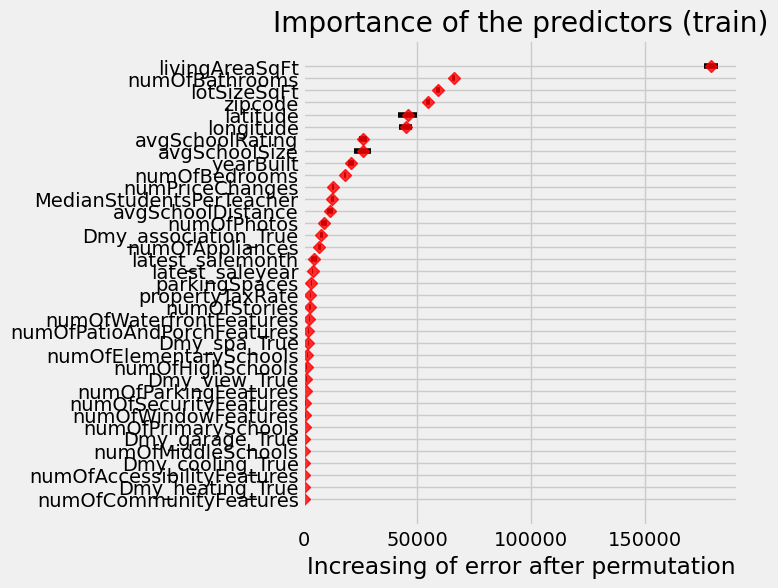

In [36]:
# Graphic
fig, ax = plt.subplots(figsize=(5, 6))
df_importance = df_importance.sort_values('importances_mean', ascending=True)
ax.barh(
    df_importance['feature'],
    df_importance['importances_mean'],
    xerr=df_importance['importances_std'],
    align='center',
    alpha=0
)
ax.plot(
    df_importance['importances_mean'],
    df_importance['feature'],
    marker="D",
    linestyle="",
    alpha=0.8,
    color="r"
)
ax.set_title('Importance of the predictors (train)')
ax.set_xlabel('Increasing of error after permutation');

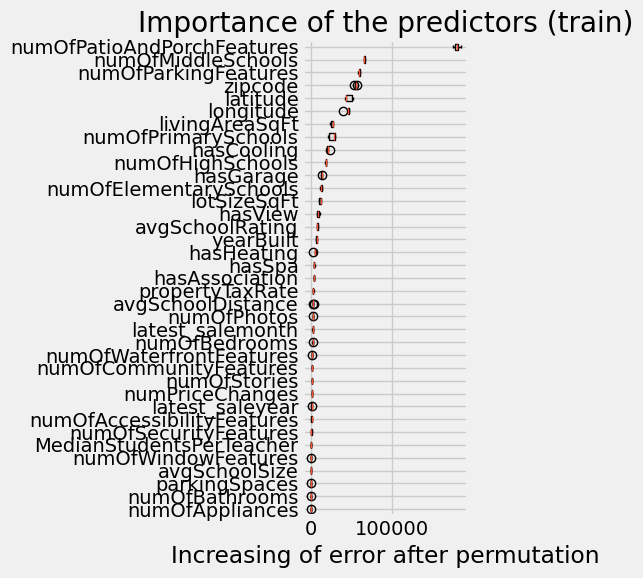

In [37]:
# Graphic Alternative
fig, ax = plt.subplots(figsize=(5, 6))
sorted_idx = importance_per.importances_mean.argsort()
ax.boxplot(
        importance_per.importances[sorted_idx].T,
        vert   = False,
        labels = data_train.drop(columns = "latestPrice").columns[sorted_idx]
)
ax.set_title('Importance of the predictors (train)')
ax.set_xlabel('Increasing of error after permutation');
fig.tight_layout();

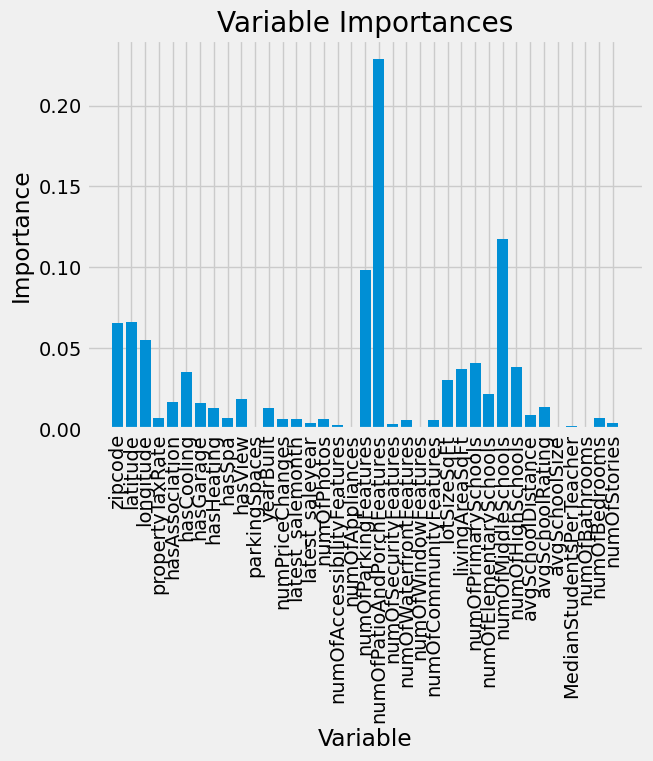

In [38]:
importances= model_final.feature_importances_
feature_list = data_train.drop(columns = "latestPrice").columns

%matplotlib inline
# Set the style
plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

In [39]:
# Model training error
#-------------------------------------------------------------------------------
prediction_train = model_final.predict(X = X_train)


#Measuring Goodness of fit in Training data

print('R2 Value in training:', round(metrics.r2_score(y_train, prediction_train),2))

#Measuring accuracy on Testing Data
print('Accuracy in training',round( 100- (np.mean(np.abs((y_train - prediction_train) / y_train)) * 100), 2))
      
 
residuals_train=y_train - prediction_train


rmse = mean_squared_error(
        y_true  = y_train,
        y_pred  = prediction_train,
        squared = False
       )
print(f"RMSE in train: {rmse}")

R2 Value in training: 0.93
Accuracy in training 89.17
RMSE in train: 123688.63831188642


In [40]:
# Model test error
#-------------------------------------------------------------------------------
prediction_test = model_final.predict(X = X_test)


#Measuring accuracy on Testing Data
print('Accuracy in test',round( 100- (np.mean(np.abs((y_test - prediction_test) / y_test)) * 100), 2))
      
 
residuals_testn=y_test - prediction_test

rmse = mean_squared_error(
        y_true  = y_test,
        y_pred  = prediction_test,
        squared = False
       )
print(f"RMSE in test: {rmse}")

Accuracy in test 58.98
RMSE in test: 185378.44210833308


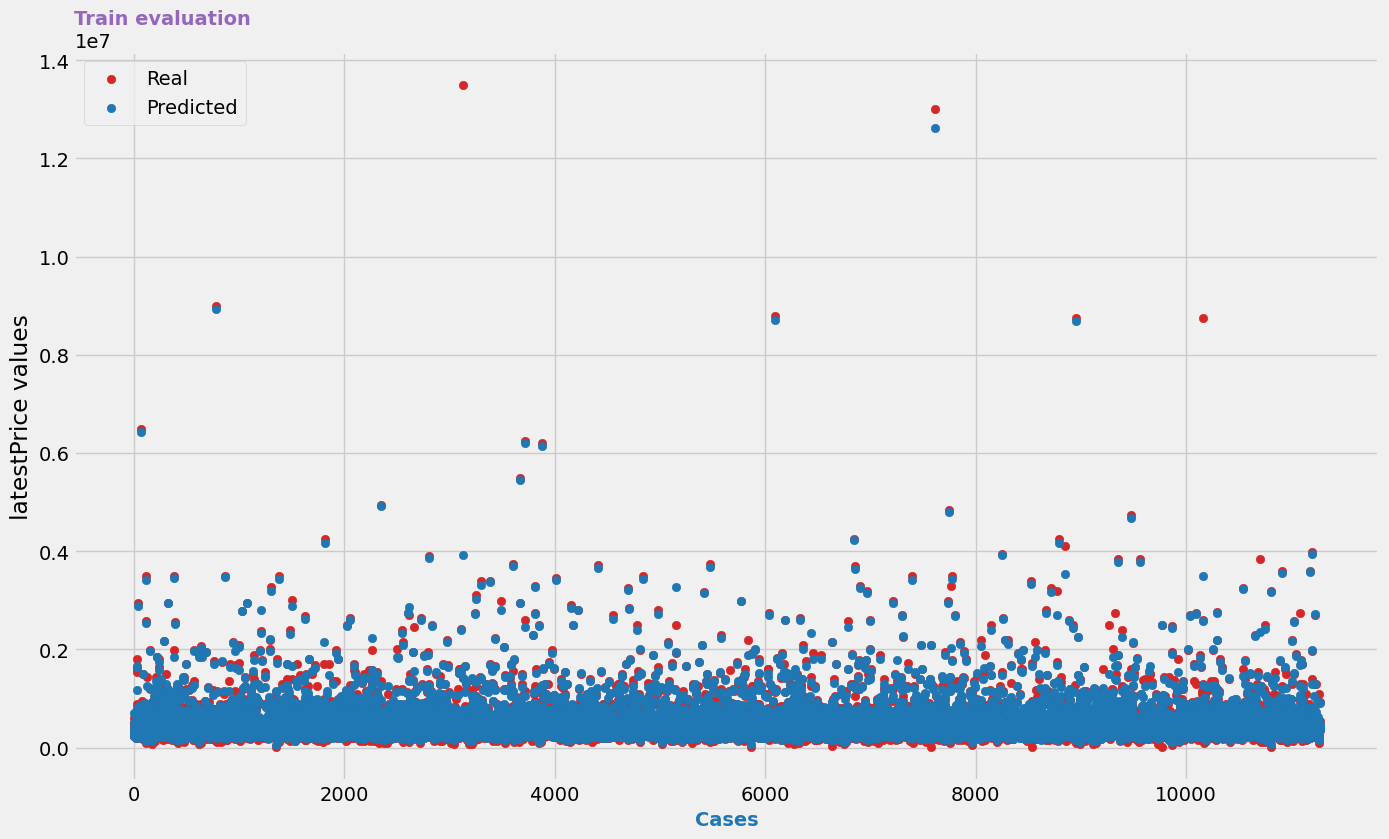

In [41]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15, 9))


x_axis=list(range(len(y_train)))

ax.scatter(x_axis, y_train, color = 'tab:red', label='Real')
ax.scatter(x_axis, prediction_train, color = 'tab:blue', label='Predicted')
ax.set_xlabel("Cases", fontdict = {'fontsize':14, 'fontweight':'bold', 'color':'tab:blue'})
ax.set_ylabel("latestPrice values")
ax.set_title('Train evaluation', loc = "left", fontdict = {'fontsize':14, 'fontweight':'bold', 'color':'tab:purple'})
ax.legend(loc = 'upper left')
plt.show()

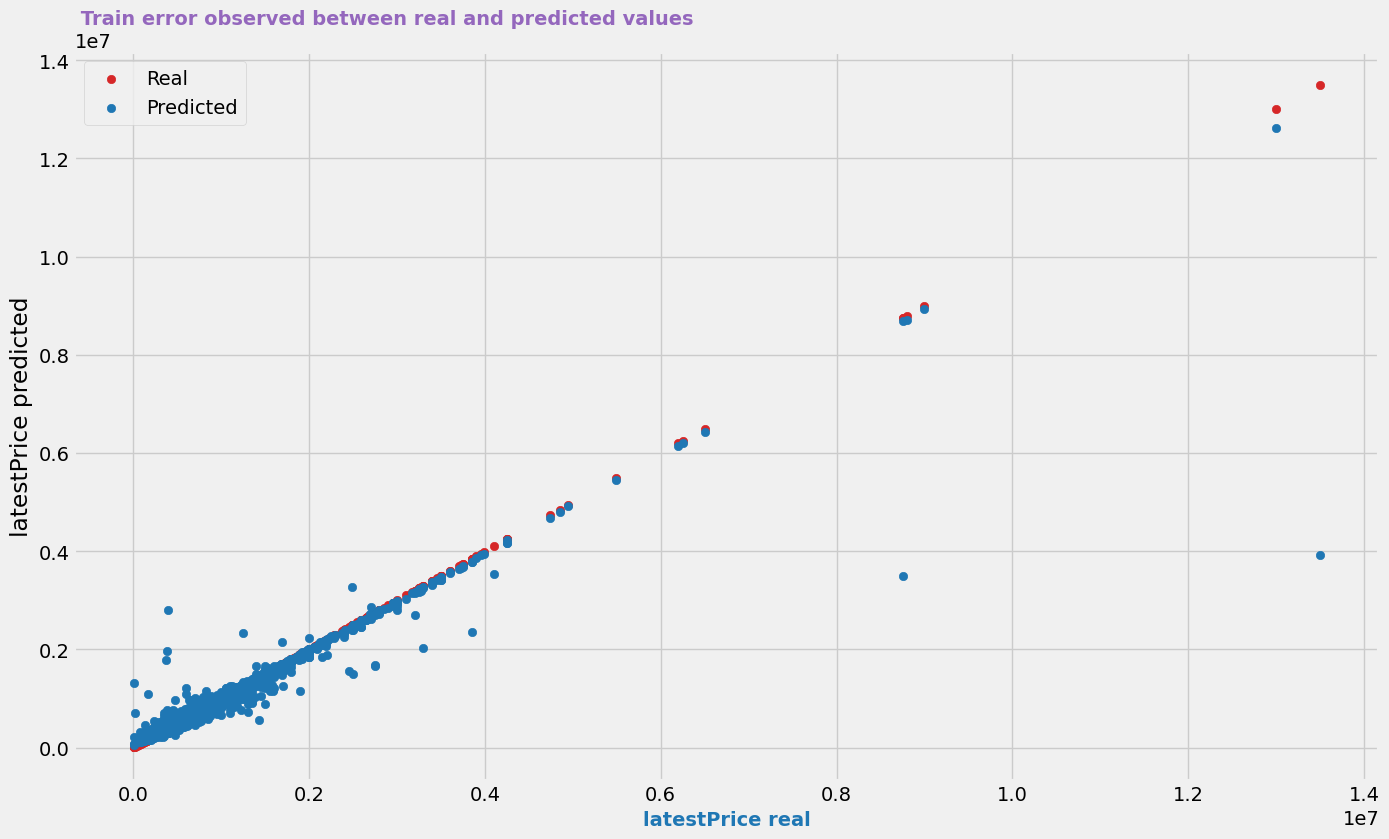

In [42]:
#######  TRAIN

fig, ax = plt.subplots(figsize=(15, 9))


#x_axis=list(range(len(y_train)))

ax.scatter(y_train, y_train, color = 'tab:red', label='Real')
ax.scatter(y_train, prediction_train, color = 'tab:blue', label='Predicted')
ax.set_xlabel("latestPrice real", fontdict = {'fontsize':14, 'fontweight':'bold', 'color':'tab:blue'})
ax.set_ylabel("latestPrice predicted")
ax.set_title(' Train error observed between real and predicted values', loc = "left", fontdict = {'fontsize':14, 'fontweight':'bold', 'color':'tab:purple'})
ax.legend(loc = 'upper left')
plt.show()

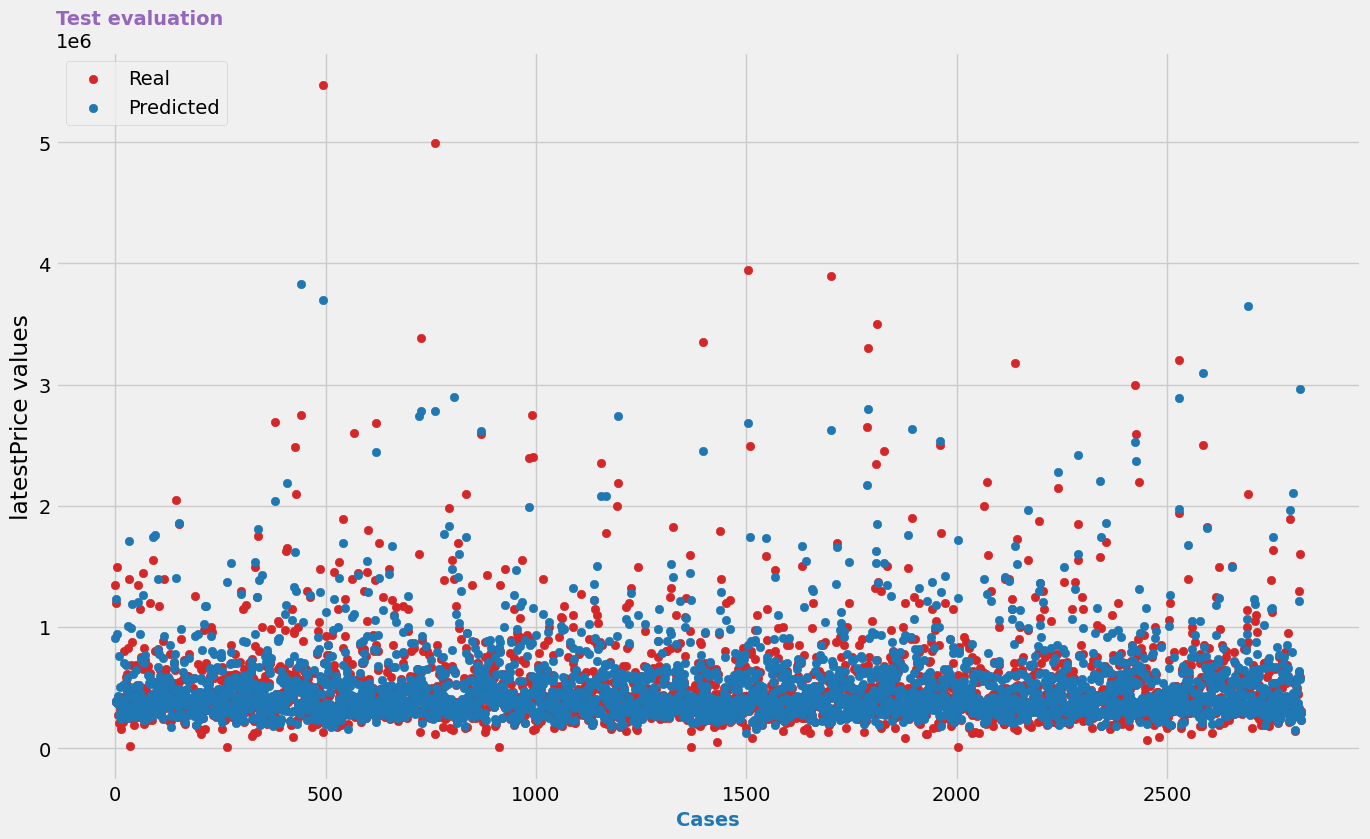

In [43]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15, 9))


x_axis=list(range(len(y_test)))

ax.scatter(x_axis, y_test, color = 'tab:red', label='Real')
ax.scatter(x_axis, prediction_test, color = 'tab:blue', label='Predicted')
ax.set_xlabel("Cases", fontdict = {'fontsize':14, 'fontweight':'bold', 'color':'tab:blue'})
ax.set_ylabel("latestPrice values")
ax.set_title('Test evaluation', loc = "left", fontdict = {'fontsize':14, 'fontweight':'bold', 'color':'tab:purple'})
ax.legend(loc = 'upper left')
plt.show()

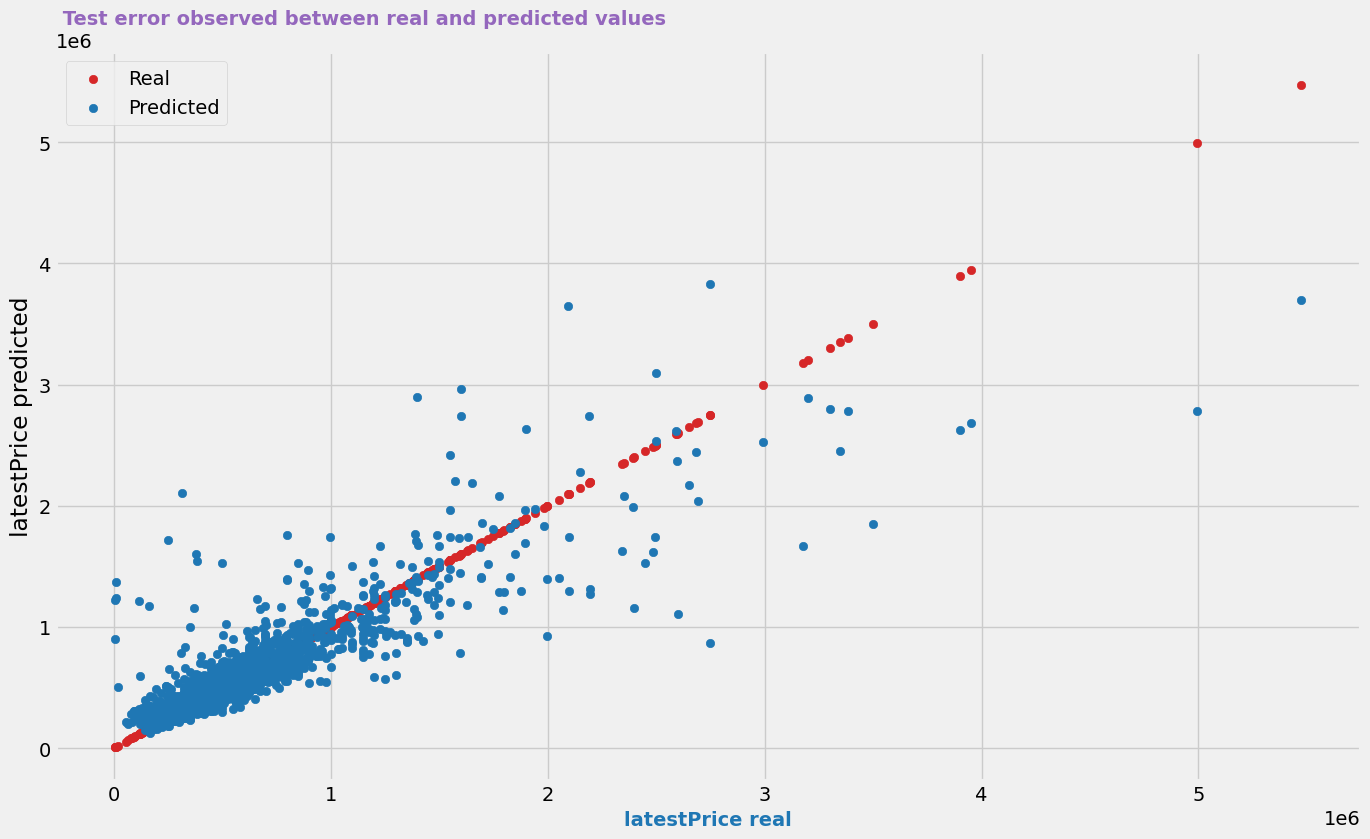

In [44]:
#######  TEST

fig, ax = plt.subplots(figsize=(15, 9))


#x_axis=list(range(len(y_train)))

ax.scatter(y_test, y_test, color = 'tab:red', label='Real')
ax.scatter(y_test, prediction_test, color = 'tab:blue', label='Predicted')
ax.set_xlabel("latestPrice real", fontdict = {'fontsize':14, 'fontweight':'bold', 'color':'tab:blue'})
ax.set_ylabel("latestPrice predicted")
ax.set_title(' Test error observed between real and predicted values', loc = "left", fontdict = {'fontsize':14, 'fontweight':'bold', 'color':'tab:purple'})
ax.legend(loc = 'upper left')
plt.show()

In [45]:
# Model based on LightGBM
# - Allows observations to include missing values
# - Allows the use of GPUs
# - Parallelized training (parallelizes some parts of the algorithm)
# - Allow monotonic constraints
# - Allows working on sparse matrices
# - No need for one-hot-encoding of categorical variables


In [46]:
# Installation LightGBM: conda install -c conda-forge lightgbm
from lightgbm.sklearn import LGBMRegressor

In [50]:
# Grid of hiperparameters to evaluate 
# ==============================================================================
param_grid = {'n_estimators'     : [100, 500, 1000],
              'max_depth'        : [-1, 1, 3, 5, 10],
              'subsample'        : [0.5, 1],
              'learning_rate'    : [0.001, 0.01, 0.1],
              'boosting_type'    : ['gbdt']
             }

# grid search with CV
# ==============================================================================
grid = GridSearchCV(
        estimator  = LGBMRegressor(random_state=123,
                                   min_split_gain=0.1
                                   ),
        param_grid = param_grid,
        scoring    = 'neg_root_mean_squared_error',
        n_jobs     = multiprocessing.cpu_count() - 1,
        cv         = RepeatedKFold(n_splits=3, n_repeats=1, random_state=123), 
        refit      = True,
        verbose    = 0,
        return_train_score = True,
       )

grid.fit(X = X_train_grid, y = y_train_grid)

# Resultados
# ==============================================================================
results = pd.DataFrame(grid.cv_results_)
results.filter(regex = '(param.*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False) \
    .head(4)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007072 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1799
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006225 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1795
[LightGBM] [Info] Number of data points in the train set: 6766, number of used features: 36
[LightGBM] [Info] Number of data points in the train set: 6766, number of used features: 36
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005961 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1799
[LightGBM] [Info] Number of data points in the train set: 6766, number of used features: 36
[LightGB

param_boosting_type param_learning_rate param_max_depth param_n_estimators  \
57                gbdt                0.01              10                500   
56                gbdt                0.01              10                500   
53                gbdt                0.01               5               1000   
52                gbdt                0.01               5               1000   

   param_subsample  mean_test_score  std_test_score  mean_train_score  \
57               1   -253088.272687    42382.544768    -180683.298320   
56             0.5   -253088.272687    42382.544768    -180683.298320   
53               1   -253201.799064    42720.445431    -175022.016844   
52             0.5   -253201.799064    42720.445431    -175022.016844   

    std_train_score  
57      16398.94872  
56      16398.94872  
53      10937.69821  
52      10937.69821

In [51]:
# Best hiperparameters using CV
# ==============================================================================
print("----------------------------------------")
print("Best hiperparameters found (cv)")
print("----------------------------------------")
print(grid.best_params_, ":", grid.best_score_, grid.scoring)

----------------------------------------
Best hiperparameters found (cv)
----------------------------------------
{'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 500, 'subsample': 0.5} : -253088.2726872452 neg_root_mean_squared_error


In [70]:
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.01,
    'max_depth': 10,
    'n_estimators': 500, 
    'subsample' : 0.5,
    'num_leaves': 31,    
    'verbose': -1,
    'early_stopping_rounds' : 50,
}

In [68]:
#train_data = lightgbm.Dataset(X_train, label=y_train)
#valid_data = lightgbm.Dataset(X_test, label=y_test)

In [73]:
#model_light_final = lightgbm.train(params, train_data, 1000, valid_sets=[train_data, valid_data])

In [77]:
# Selecting Best model
model_light_final = grid.best_estimator_

In [78]:
# Final Model training error
#-------------------------------------------------------------------------------
prediction_train = model_light_final.predict(X_train)


#Measuring Goodness of fit in Training data

print('R2 Value in training:', round(metrics.r2_score(y_train, prediction_train),2))

#Measuring accuracy on Testing Data
print('Accuracy in training',round( 100- (np.mean(np.abs((y_train - prediction_train) / y_train)) * 100), 2))
      
 
residuals_train=y_train - prediction_train


rmse = mean_squared_error(
        y_true  = y_train,
        y_pred  = prediction_train,
        squared = False
       )
print(f"RMSE in train: {rmse}")

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
R2 Value in training: 0.8
Accuracy in training 77.42
RMSE in train: 204741.79634233742


In [79]:
# Model test error
#-------------------------------------------------------------------------------
prediction_test = model_light_final.predict(X_test)


#Measuring accuracy on Testing Data
print('Accuracy in test',round( 100- (np.mean(np.abs((y_test - prediction_test) / y_test)) * 100), 2))
      
 
residuals_testn=y_test - prediction_test

rmse = mean_squared_error(
        y_true  = y_test,
        y_pred  = prediction_test,
        squared = False
       )
print(f"RMSE in test: {rmse}")

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Accuracy in test 60.69
RMSE in test: 183505.11034901426


In [55]:
importance_predictors = pd.DataFrame(
                            {'predictor': data_train.drop(columns = "latestPrice").columns,
                             'importance': model_light_final.feature_importances_}
                            )
print("Importance of the model predictors")
print("-------------------------------------------")
importance_predictors.sort_values('importance', ascending=False)

Importance of the model predictors
-------------------------------------------


predictor  importance
19  numOfPatioAndPorchFeatures        2813
1                     latitude        1695
2                    longitude        1517
18        numOfParkingFeatures        1315
5                   hasCooling        1161
6                    hasGarage         955
0                      zipcode         900
26         numOfPrimarySchools         557
25              livingAreaSqFt         556
9                      hasView         499
28          numOfMiddleSchools         494
24                 lotSizeSqFt         400
8                       hasSpa         387
31             avgSchoolRating         241
11                   yearBuilt         225
4               hasAssociation         211
7                   hasHeating         169
3              propertyTaxRate         158
13            latest_salemonth         144
29            numOfHighSchools         135
27      numOfElementarySchools          94
30           avgSchoolDistance          91
35               numOfBedrooms          84
36                numOfStories          47
21     numOfWaterfrontFeatures          40
12             numPriceChanges          37
23      numOfCommunityFeatures          31
14             latest_saleyear          19
34              numOfBathrooms           9
20       numOfSecurityFeatures           7
22         numOfWindowFeatures           4
32               avgSchoolSize           3
16  numOfAccessibilityFeatures           2
17             numOfAppliances           0
15                 numOfPhotos           0
33    MedianStudentsPerTeacher           0
10               parkingSpaces           0

In [56]:
from sklearn.inspection import permutation_importance

importance_per = permutation_importance(
                estimator    = model_light_final,
                X            = X_train,
                y            = y_train,
                n_repeats    = 5,
                scoring      = 'neg_root_mean_squared_error',
                n_jobs       = - 1,
                random_state = 123
             )

# Se almacenan los resultados (media y desviación) en un dataframe
df_importance = pd.DataFrame(
                    {k: importance_per[k] for k in ['importances_mean', 'importances_std']}
                 )
df_importance['feature'] = X_train.columns
df_importance.sort_values('importances_mean', ascending=False)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^m

importances_mean  importances_std                     feature
19     194295.425119      2249.747547              livingAreaSqFt
28      51852.606734       291.208244              numOfBathrooms
0       47869.480266      1266.878663                     zipcode
2       47343.383324      3417.802847                   longitude
1       41317.378336      3051.176863                    latitude
18      35647.870397       868.839242                 lotSizeSqFt
25      17688.723562       509.050564             avgSchoolRating
5       15883.938179       499.715484                   yearBuilt
6       11813.578109       459.934578             numPriceChanges
26       9985.685379      1163.197501               avgSchoolSize
31       8028.017631       330.679990        Dmy_association_True
8        7955.447263       843.908038             latest_saleyear
24       5938.394413      1434.121531           avgSchoolDistance
11       4788.087009       809.313212             numOfAppliances
9        3874.540320       742.597605                 numOfPhotos
3        2037.543378       147.709343             propertyTaxRate
13       1523.716853       384.856057  numOfPatioAndPorchFeatures
30       1486.536595       273.951561                numOfStories
7        1374.093448       275.320832            latest_salemonth
4        1058.307473        58.070452               parkingSpaces
35        461.818341        33.637933                Dmy_spa_True
27        421.419303        96.150448    MedianStudentsPerTeacher
21        340.447258        23.240401      numOfElementarySchools
23        218.931892        42.805572            numOfHighSchools
36        189.690125        55.691071               Dmy_view_True
29        115.548008        42.039834               numOfBedrooms
12         65.136773        14.943666        numOfParkingFeatures
14         55.583245         8.142071       numOfSecurityFeatures
22         32.867498         5.635074          numOfMiddleSchools
34         10.784891         1.844526            Dmy_heating_True
20          8.034898         1.541904         numOfPrimarySchools
16          6.205229         1.931037         numOfWindowFeatures
32          4.028903         0.289129            Dmy_cooling_True
17          0.000000         0.000000      numOfCommunityFeatures
15          0.000000         0.000000     numOfWaterfrontFeatures
33          0.000000         0.000000             Dmy_garage_True
10          0.000000         0.000000  numOfAccessibilityFeatures

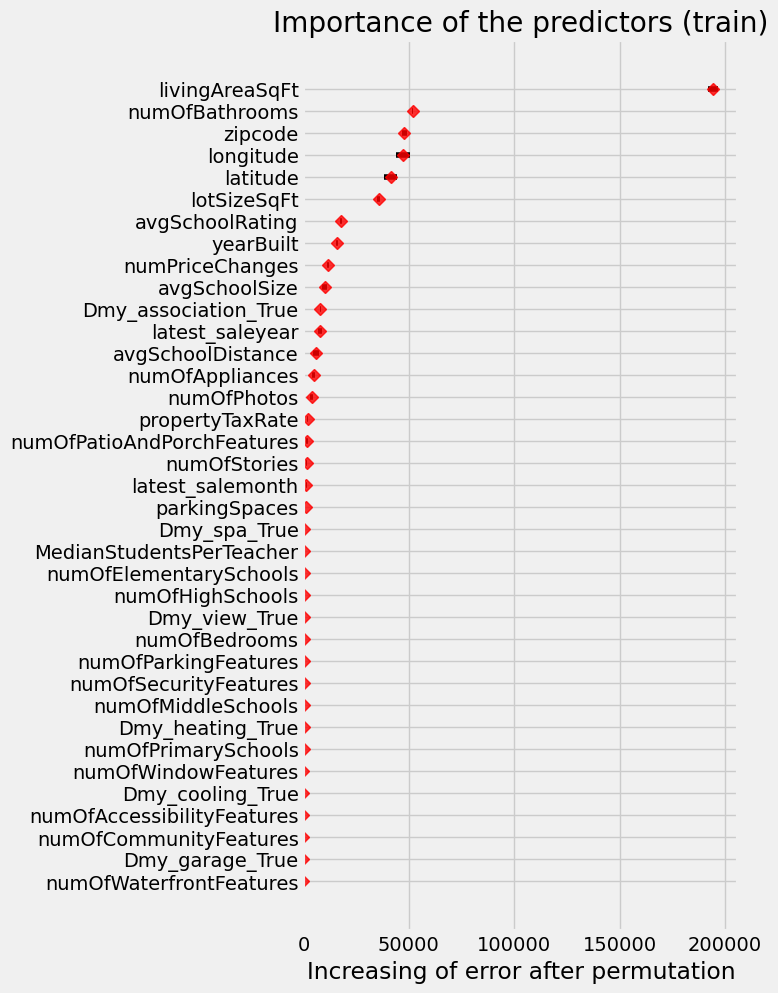

In [65]:
# Graphic
fig, ax = plt.subplots(figsize=(5, 11))
df_importance = df_importance.sort_values('importances_mean', ascending=True)
ax.barh(
    df_importance['feature'],
    df_importance['importances_mean'],
    xerr=df_importance['importances_std'],
    align='center',
    alpha=0
)
ax.plot(
    df_importance['importances_mean'],
    df_importance['feature'],
    marker="D",
    linestyle="",
    alpha=0.8,
    color="r"
)
ax.set_title('Importance of the predictors (train)')
ax.set_xlabel('Increasing of error after permutation');

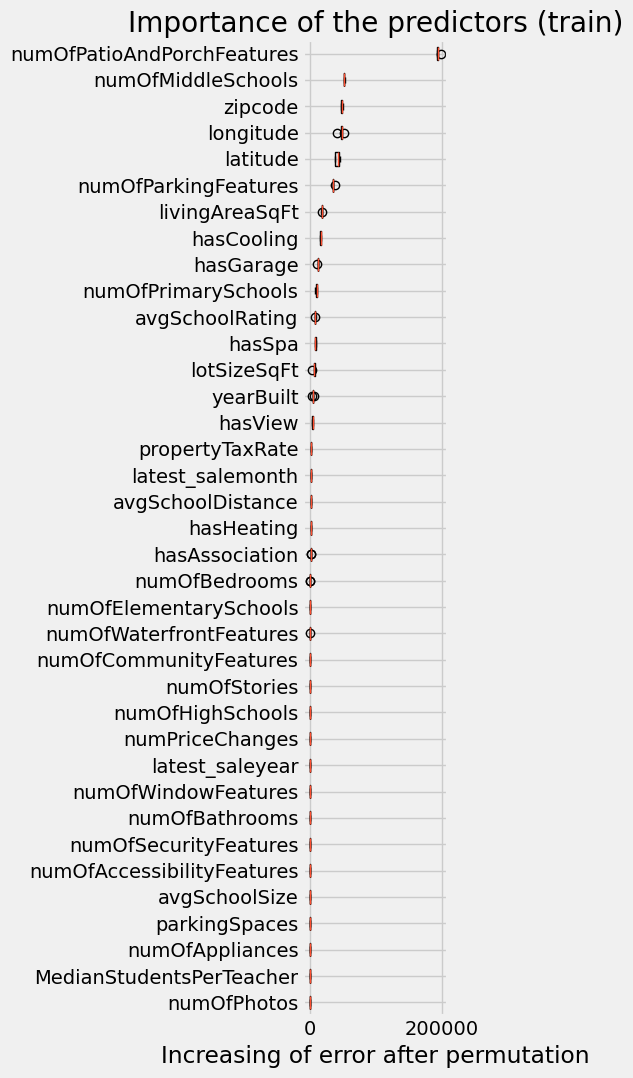

In [66]:
# Graphic Alternative
fig, ax = plt.subplots(figsize=(5, 11))
sorted_idx = importance_per.importances_mean.argsort()
ax.boxplot(
        importance_per.importances[sorted_idx].T,
        vert   = False,
        labels = data_train.drop(columns = "latestPrice").columns[sorted_idx]
)
ax.set_title('Importance of the predictors (train)')
ax.set_xlabel('Increasing of error after permutation');
fig.tight_layout();

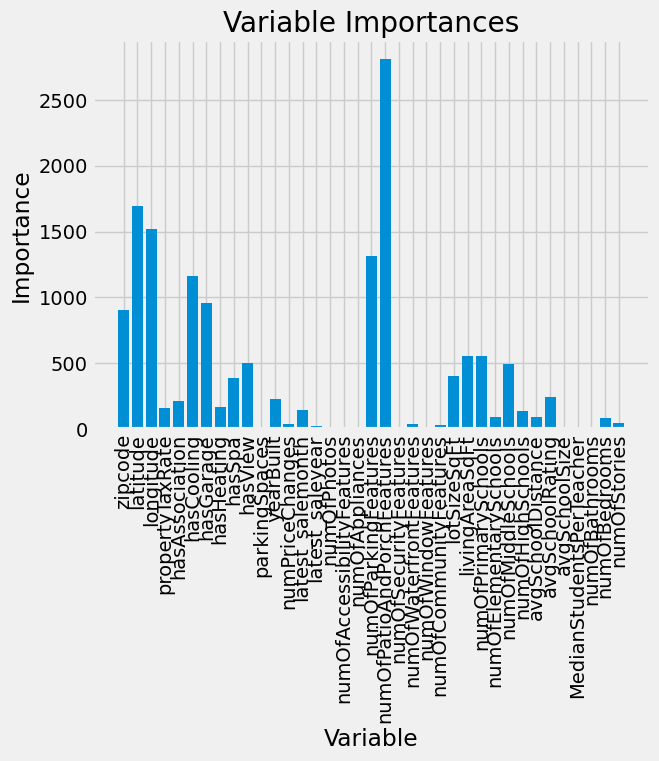

In [59]:
importances= model_light_final.feature_importances_
feature_list = data_train.drop(columns = "latestPrice").columns

%matplotlib inline
# Set the style
plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

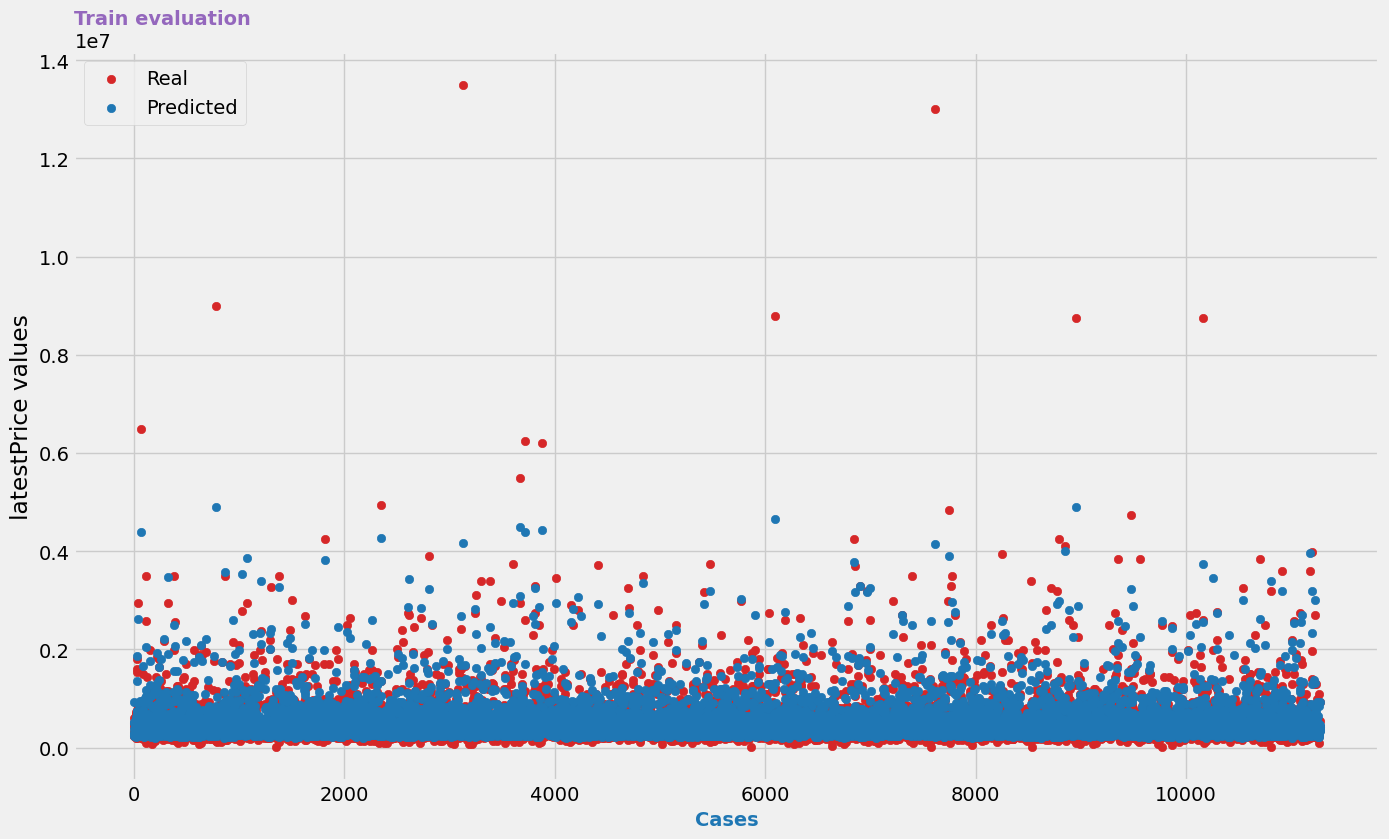

In [60]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15, 9))


x_axis=list(range(len(y_train)))

ax.scatter(x_axis, y_train, color = 'tab:red', label='Real')
ax.scatter(x_axis, prediction_train, color = 'tab:blue', label='Predicted')
ax.set_xlabel("Cases", fontdict = {'fontsize':14, 'fontweight':'bold', 'color':'tab:blue'})
ax.set_ylabel("latestPrice values")
ax.set_title('Train evaluation', loc = "left", fontdict = {'fontsize':14, 'fontweight':'bold', 'color':'tab:purple'})
ax.legend(loc = 'upper left')
plt.show()

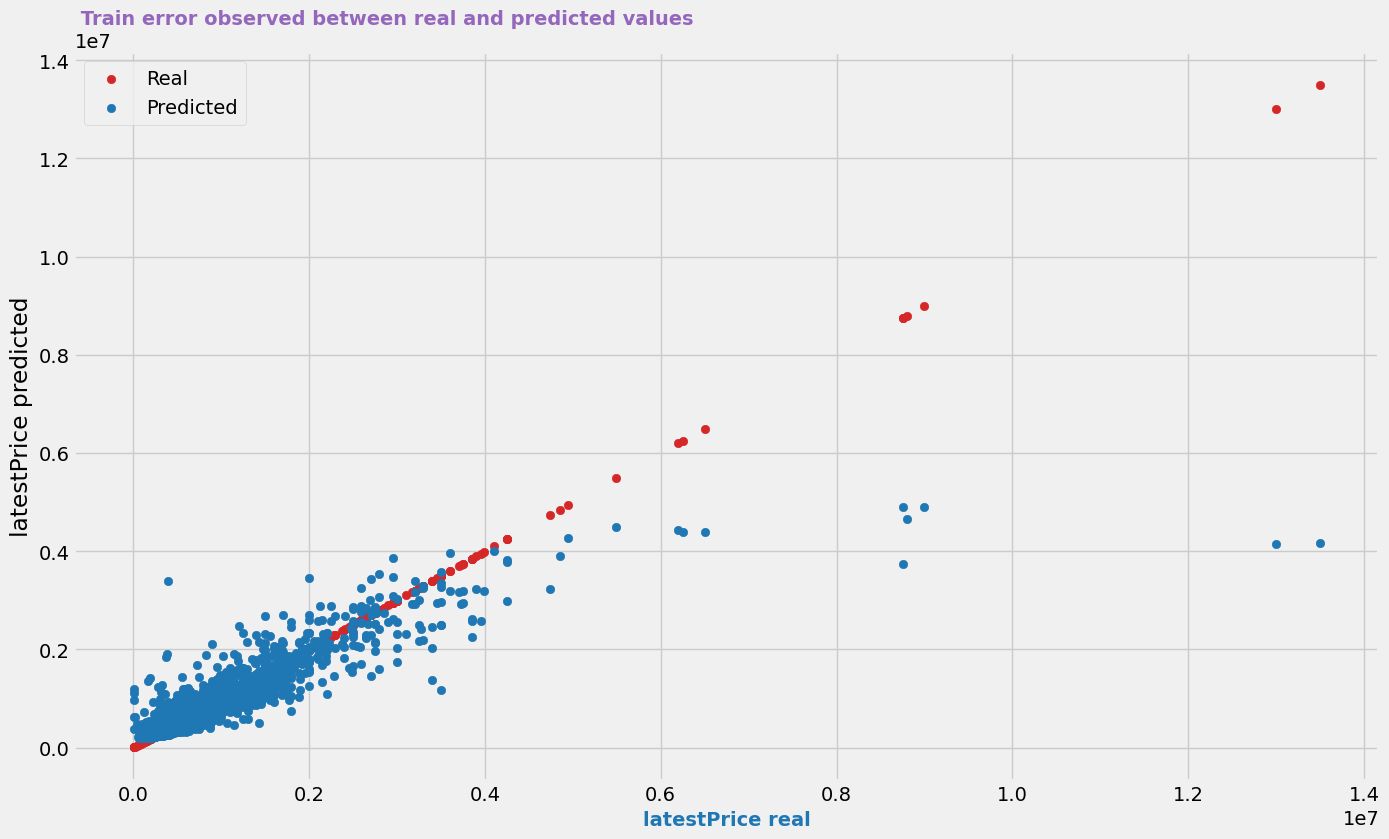

In [61]:
#######  TRAIN

fig, ax = plt.subplots(figsize=(15, 9))


#x_axis=list(range(len(y_train)))

ax.scatter(y_train, y_train, color = 'tab:red', label='Real')
ax.scatter(y_train, prediction_train, color = 'tab:blue', label='Predicted')
ax.set_xlabel("latestPrice real", fontdict = {'fontsize':14, 'fontweight':'bold', 'color':'tab:blue'})
ax.set_ylabel("latestPrice predicted")
ax.set_title(' Train error observed between real and predicted values', loc = "left", fontdict = {'fontsize':14, 'fontweight':'bold', 'color':'tab:purple'})
ax.legend(loc = 'upper left')
plt.show()

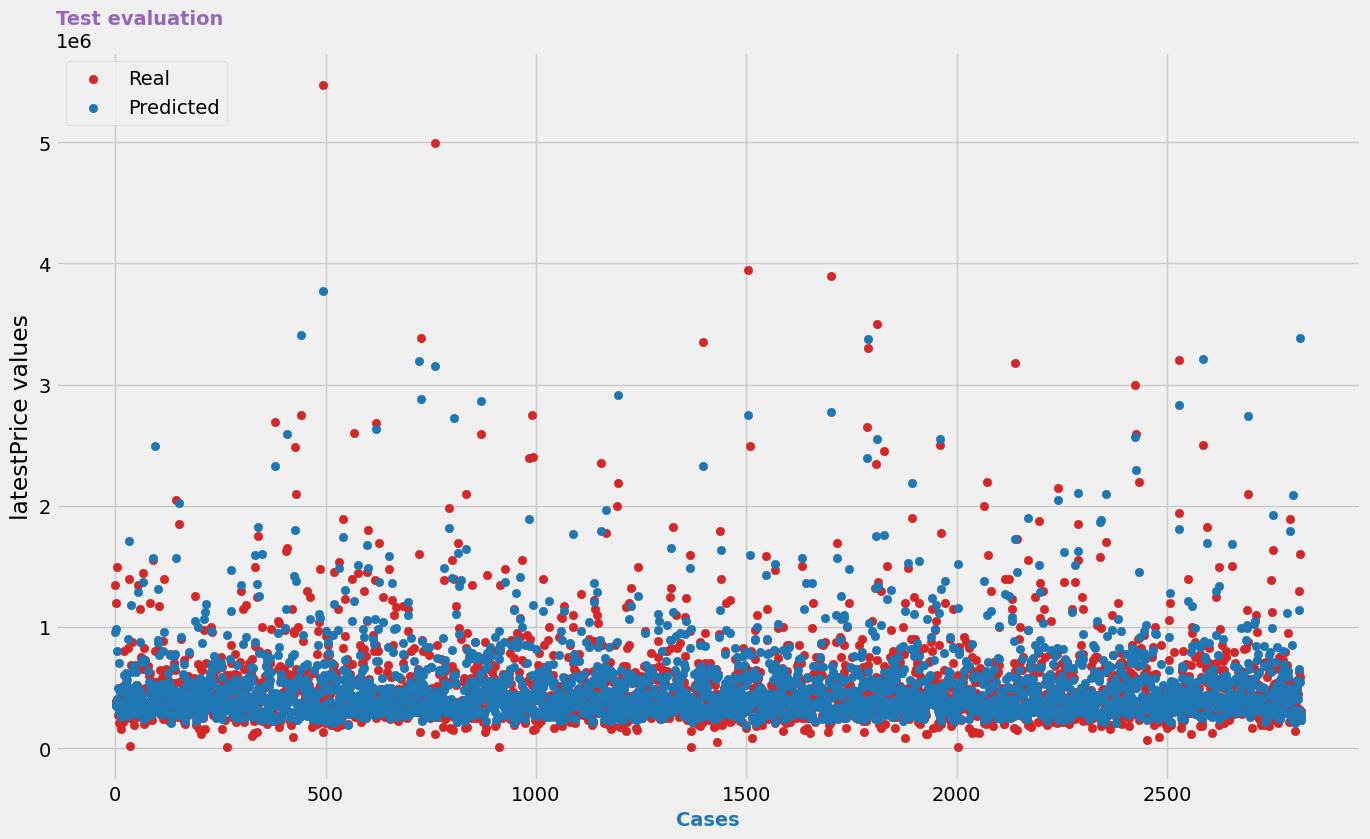

In [62]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15, 9))


x_axis=list(range(len(y_test)))

ax.scatter(x_axis, y_test, color = 'tab:red', label='Real')
ax.scatter(x_axis, prediction_test, color = 'tab:blue', label='Predicted')
ax.set_xlabel("Cases", fontdict = {'fontsize':14, 'fontweight':'bold', 'color':'tab:blue'})
ax.set_ylabel("latestPrice values")
ax.set_title('Test evaluation', loc = "left", fontdict = {'fontsize':14, 'fontweight':'bold', 'color':'tab:purple'})
ax.legend(loc = 'upper left')
plt.show()

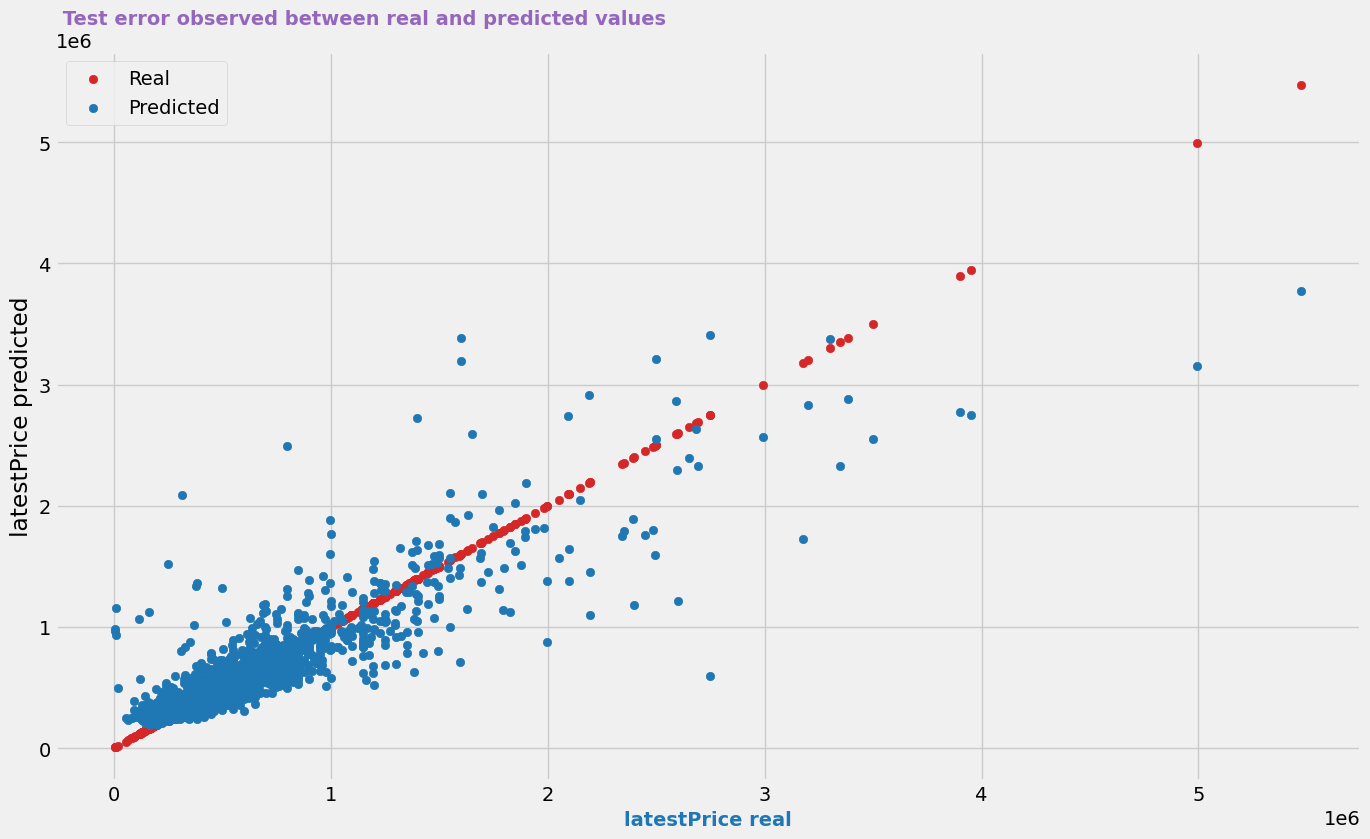

In [63]:
#######  TEST

fig, ax = plt.subplots(figsize=(15, 9))


#x_axis=list(range(len(y_train)))

ax.scatter(y_test, y_test, color = 'tab:red', label='Real')
ax.scatter(y_test, prediction_test, color = 'tab:blue', label='Predicted')
ax.set_xlabel("latestPrice real", fontdict = {'fontsize':14, 'fontweight':'bold', 'color':'tab:blue'})
ax.set_ylabel("latestPrice predicted")
ax.set_title(' Test error observed between real and predicted values', loc = "left", fontdict = {'fontsize':14, 'fontweight':'bold', 'color':'tab:purple'})
ax.legend(loc = 'upper left')
plt.show()